In [3]:
import pandas as pd

### Verify step 2

In [4]:
ev_vf_df = pd.read_csv('data/ev-verification.csv')
mx_vf_df = pd.read_csv('data/max-verification.csv')
gm_df = pd.read_csv('data/gemini-coding.csv')

In [136]:
# Merge on unique identifiers
merged = pd.merge(ev_vf_df, mx_vf_df, on=['transcript', 'timestamp'], suffixes=('_ev', '_mx'))

In [137]:
from sklearn.metrics import cohen_kappa_score


codes = ['c1', 'c2', 'c3', 'c4']
kappa_results = {}

for code_name in set(merged[[f'{c}_ev' for c in codes] + [f'{c}_mx' for c in codes]].values.flatten()):
    if pd.isna(code_name):
        continue
    ev_vf_list = []
    mx_vf_list = []
    for _, row in merged.iterrows():
        # Find which column in ev and mx has this code_name
        ev_code_col = next((f'{c}_ev' for c in codes if row[f'{c}_ev'] == code_name), None)
        mx_code_col = next((f'{c}_mx' for c in codes if row[f'{c}_mx'] == code_name), None)
        if ev_code_col and mx_code_col:
            ev_vf_col = ev_code_col.replace('_ev', '-vf_ev')
            mx_vf_col = mx_code_col.replace('_mx', '-vf_mx')
            ev_vf = row[ev_vf_col]
            mx_vf = row[mx_vf_col]
            if pd.notna(ev_vf) and pd.notna(mx_vf):
                ev_vf_list.append(ev_vf)
                mx_vf_list.append(mx_vf)
    if ev_vf_list and mx_vf_list:
        print(f"Calculating Cohen's kappa for code '{code_name}', number of valid entries: {len(ev_vf_list)} in ev, {len(mx_vf_list)} in mx")
        kappa = cohen_kappa_score(ev_vf_list, mx_vf_list, weights='quadratic')
        kappa_results[code_name] = kappa

for code, kappa in kappa_results.items():
    print(f"Cohen's kappa for code '{code}': {kappa}")

Calculating Cohen's kappa for code 'express agreement ', number of valid entries: 10 in ev, 10 in mx
Calculating Cohen's kappa for code 'provide supporting evidence', number of valid entries: 33 in ev, 33 in mx
Calculating Cohen's kappa for code 'ask clarifying question', number of valid entries: 18 in ev, 18 in mx
Calculating Cohen's kappa for code 'present new idea', number of valid entries: 36 in ev, 36 in mx
Calculating Cohen's kappa for code 'express alternative decision', number of valid entries: 1 in ev, 1 in mx
Calculating Cohen's kappa for code 'encourage particpatioin', number of valid entries: 7 in ev, 7 in mx
Calculating Cohen's kappa for code 'acknowledge contribution', number of valid entries: 18 in ev, 18 in mx
Calculating Cohen's kappa for code 'assign task', number of valid entries: 2 in ev, 2 in mx
Calculating Cohen's kappa for code 'express humor', number of valid entries: 1 in ev, 1 in mx
Calculating Cohen's kappa for code 'reject idea', number of valid entries: 1 i

/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * co

In [138]:
import ast

rows = []
for idx, row in gm_df.iterrows():
    ann = row['annotations']
    # Handle both dict and list of dicts, and skip NaN
    if pd.isna(ann):
        continue
    # Convert string representation to dict/list if necessary
    if isinstance(ann, str):
        try:
            ann = ast.literal_eval(ann)
        except Exception:
            continue
    if isinstance(ann, dict):
        ann_items = ann.items()
    elif isinstance(ann, list):
        ann_items = []
        for d in ann:
            if isinstance(d, dict):
                ann_items.extend(d.items())
    else:
        continue
    for key, value in ann_items:
        rows.append({
            'folder': row['folder'],
            'file': row['file'],
            'timestamp': row['timestamp'],
            'speaker': row['speaker'],
            'ai_code': key,
            'ai_explanation': value
        })

ai_ann_df = pd.DataFrame(rows, columns=['folder', 'file', 'timestamp', 'speaker', 'ai_code', 'ai_explanation'])

In [132]:
print(ai_ann_df.head())

                             folder  \
0  2021MND/output_2021_04_22_MND_S6   
1  2021MND/output_2021_04_22_MND_S6   
2  2021MND/output_2021_04_22_MND_S6   
3  2021MND/output_2021_04_22_MND_S6   
4  2021MND/output_2021_04_22_MND_S6   

                                                file      timestamp  \
0  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    00:28-00:44   
1  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    03:00-03:34   
2  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    03:00-03:34   
3  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    01:01-02:30   
4  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...  [07:44-08:47]   

                speaker                            ai_code  \
0         Nandita Garud           acknowledge contribution   
1            Mark Mimee  explain or define term or concept   
2            Mark Mimee                   present new idea   
3         Nandita Garud                summarize key ideas   
4  Dr. Ali Keshavarzian     

In [141]:
print(ev_vf_df.columns)

Index(['link to video', 'timestamp', 'speaker', 'transcript', 'annotations',
       'c1', 'c1-vf', 'c1-ep', 'c2', 'c2-vf', 'c2-ep', 'c3', 'c3-vf', 'c3-ep',
       'c4', 'c4-vf', 'c4-ep', 'notes1', 'notes2'],
      dtype='object')


In [142]:
# Add new columns to ai_ann_df
ai_ann_df['ev_vf'] = None
ai_ann_df['ev_exp'] = None
ai_ann_df['mx_vf'] = None
ai_ann_df['mx_exp'] = None
ai_ann_df['link to video'] = None
ai_ann_df['ev_notes'] = None
ai_ann_df['mx_notes'] = None

for idx, ann_row in ai_ann_df.iterrows():
    ts = ann_row['timestamp']
    sp = ann_row['speaker']
    code = ann_row['ai_code']

    # Find matching row in ev_df
    ev_match = ev_vf_df[(ev_vf_df['timestamp'] == ts) & (ev_vf_df['speaker'] == sp)]
    if not ev_match.empty:
        for c in ['c1', 'c2', 'c3', 'c4']:
            if ev_match.iloc[0][c] == code:
                ai_ann_df.at[idx, 'ev_vf'] = ev_match.iloc[0][f'{c}-vf']
                ai_ann_df.at[idx, 'ev_exp'] = ev_match.iloc[0].get(f'{c}-ep', None)
                ai_ann_df.at[idx, 'link to video'] = ev_match.iloc[0].get('link to video', None)
                ai_ann_df.at[idx, 'ev_notes'] = str(ev_match.iloc[0]['notes1']) + ' ' + str(ev_match.iloc[0]['notes2'])
                break

    # Find matching row in mx_df
    mx_match = mx_vf_df[(mx_vf_df['timestamp'] == ts) & (mx_vf_df['speaker'] == sp)]
    if not mx_match.empty:
        for c in ['c1', 'c2', 'c3', 'c4']:
            if mx_match.iloc[0][c] == code:
                ai_ann_df.at[idx, 'mx_vf'] = mx_match.iloc[0][f'{c}-vf']
                ai_ann_df.at[idx, 'mx_exp'] = mx_match.iloc[0].get(f'{c}-ep', None)
                ai_ann_df.at[idx, 'mx_notes'] = str(mx_match.iloc[0]['notes1']) + ' ' + str(mx_match.iloc[0]['notes2'])
                break

In [143]:
ai_ann_df = ai_ann_df[ai_ann_df['ev_vf'].notna() & (ai_ann_df['ev_vf'] != "")]


In [ ]:
ai_ann_df.to_csv('all_anno_vf.csv', index=False)

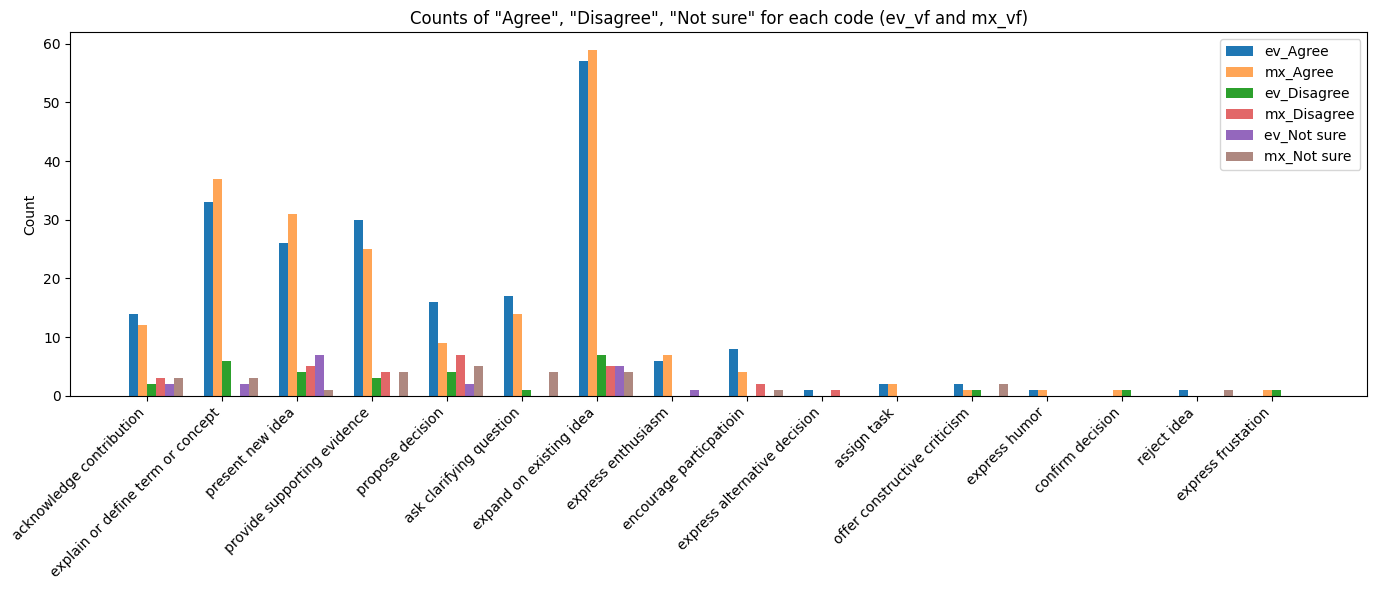

In [144]:
import matplotlib.pyplot as plt

# Get unique codes
codes = ai_ann_df['ai_code'].unique()

# Prepare a DataFrame for counts
count_data = []
for code in codes:
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    ev_counts = subset['ev_vf'].value_counts()
    mx_counts = subset['mx_vf'].value_counts()
    count_data.append({
        'code': code,
        'ev_Agree': ev_counts.get('Agree', 0),
        
        'mx_Agree': mx_counts.get('Agree', 0),

        'ev_Disagree': ev_counts.get('Disagree', 0),
        'mx_Disagree': mx_counts.get('Disagree', 0),

        'ev_Not sure': ev_counts.get('Not sure', 0),
        'mx_Not sure': mx_counts.get('Not sure', 0),
    })

counts_df = pd.DataFrame(count_data)

# Plotting
labels = ['Agree', 'Disagree', 'Not sure']
x = range(len(codes))
width = 0.12  # Make bars a bit thinner for clarity

fig, ax = plt.subplots(figsize=(14, 6))

for i, label in enumerate(labels):
    # Plot ev and mx side by side for each label
    ax.bar([p + i*2*width for p in x], counts_df[f'ev_{label}'], width, label=f'ev_{label}')
    ax.bar([p + (i*2+1)*width for p in x], counts_df[f'mx_{label}'], width, label=f'mx_{label}', alpha=0.7)

ax.set_xticks([p + 1.5*width for p in x])
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Counts of "Agree", "Disagree", "Not sure" for each code (ev_vf and mx_vf)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa_by_code = {}

for code in ai_ann_df['ai_code'].unique():
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    ev_vf = subset['ev_vf']
    mx_vf = subset['mx_vf']
    # Only keep rows where both are not null/empty
    valid = subset[ev_vf.notna() & mx_vf.notna() & (ev_vf != "") & (mx_vf != "")]
    if not valid.empty:
        print(f"Calculating Cohen's kappa for code '{code}', number of valid entries: {len(valid)}")
        kappa = cohen_kappa_score(valid['ev_vf'], valid['mx_vf'], weights='quadratic')
        kappa_by_code[code] = kappa

for code, kappa in kappa_by_code.items():
    print(f"Cohen's kappa for code '{code}': {kappa}")

Calculating Cohen's kappa for code 'acknowledge contribution', number of valid entries: 18
Calculating Cohen's kappa for code 'explain or define term or concept', number of valid entries: 40
Calculating Cohen's kappa for code 'present new idea', number of valid entries: 37
Calculating Cohen's kappa for code 'provide supporting evidence', number of valid entries: 33
Calculating Cohen's kappa for code 'propose decision', number of valid entries: 21
Calculating Cohen's kappa for code 'ask clarifying question', number of valid entries: 18
Calculating Cohen's kappa for code 'expand on existing idea', number of valid entries: 68
Calculating Cohen's kappa for code 'express enthusiasm', number of valid entries: 7
Calculating Cohen's kappa for code 'encourage particpatioin', number of valid entries: 7
Calculating Cohen's kappa for code 'express alternative decision', number of valid entries: 1
Calculating Cohen's kappa for code 'assign task', number of valid entries: 2
Calculating Cohen's kappa

/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * co

In [152]:
# Calculate simple agreement for each unique code in ai_ann_df['ai_code']
simple_agreement = {}

for code in ai_ann_df['ai_code'].unique():
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    # Only keep rows where both are not null/empty
    valid = subset[subset['ev_vf'].notna() & subset['mx_vf'].notna() & (subset['ev_vf'] != "") & (subset['mx_vf'] != "")]
    if not valid.empty:
        agreement = (valid['ev_vf'] == valid['mx_vf']).mean()
        simple_agreement[code] = agreement

for code, agreement in simple_agreement.items():
    print(f"Simple agreement for code '{code}': {agreement:.3f}")

Simple agreement for code 'acknowledge contribution': 0.667
Simple agreement for code 'explain or define term or concept': 0.825
Simple agreement for code 'present new idea': 0.649
Simple agreement for code 'provide supporting evidence': 0.727
Simple agreement for code 'propose decision': 0.476
Simple agreement for code 'ask clarifying question': 0.778
Simple agreement for code 'expand on existing idea': 0.735
Simple agreement for code 'express enthusiasm': 0.857
Simple agreement for code 'encourage particpatioin': 0.571
Simple agreement for code 'express alternative decision': 0.000
Simple agreement for code 'assign task': 1.000
Simple agreement for code 'offer constructive criticism': 0.333
Simple agreement for code 'express humor': 1.000
Simple agreement for code 'confirm decision': 0.000
Simple agreement for code 'reject idea': 0.000
Simple agreement for code 'express frustration': 0.000


In [151]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np

pabak_by_code_ev_mx_vf = {}

def pabak_from_confmat(cm):
    # cm: confusion matrix [[TN, FP], [FN, TP]]
    total = cm.sum()
    a = cm[0, 0]   
    b = cm[0, 1] 
    c = cm[1, 0] 
    d = cm[1, 1]

    BI = (b-c)/total
    PI = (a-d)/total
    if total == 0:
        return np.nan
    observed_agreement = (a+d) / total
    pabak = 2 * observed_agreement - 1
    k = (pabak - PI**2 + BI**2) / (1 - PI**2 + BI**2)
    return BI, PI, pabak, k

for code in ai_ann_df['ai_code'].unique():
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    # Only keep rows where both are not null/empty
    valid = subset[subset['ev_vf'].notna() & subset['mx_vf'].notna() & (subset['ev_vf'] != "") & (subset['mx_vf'] != "")]
    if not valid.empty:
        # Convert to binary: 1 if 'Agree', 0 otherwise (or you can use all categories if needed)
       
        agreement = (valid['ev_vf'] == valid['mx_vf']).mean()
        print(f"Simple agreement: {agreement:.3f}")
        pabak = 2 * agreement - 1

        pabak_by_code_ev_mx_vf[code] = pabak

for code, pabak in pabak_by_code_ev_mx_vf.items():
    print(f"PABAK for code '{code}': {pabak:.3f}")

Simple agreement: 0.667
Simple agreement: 0.825
Simple agreement: 0.649
Simple agreement: 0.727
Simple agreement: 0.476
Simple agreement: 0.778
Simple agreement: 0.735
Simple agreement: 0.857
Simple agreement: 0.571
Simple agreement: 0.000
Simple agreement: 1.000
Simple agreement: 0.333
Simple agreement: 1.000
Simple agreement: 0.000
Simple agreement: 0.000
Simple agreement: 0.000
PABAK for code 'acknowledge contribution': 0.333
PABAK for code 'explain or define term or concept': 0.650
PABAK for code 'present new idea': 0.297
PABAK for code 'provide supporting evidence': 0.455
PABAK for code 'propose decision': -0.048
PABAK for code 'ask clarifying question': 0.556
PABAK for code 'expand on existing idea': 0.471
PABAK for code 'express enthusiasm': 0.714
PABAK for code 'encourage particpatioin': 0.143
PABAK for code 'express alternative decision': -1.000
PABAK for code 'assign task': 1.000
PABAK for code 'offer constructive criticism': -0.333
PABAK for code 'express humor': 1.000
PABAK

In [154]:
# Create a DataFrame to display kappa scores and simple agreement scores
scores_table = pd.DataFrame({
    'Code': simple_agreement.keys(),
    'Simple Agreement': simple_agreement.values(),
    'PABAK': pabak_by_code_ev_mx_vf.values(),
})

# apply gradient to the cell backgrounds
styled_table = (scores_table.round(3)).style.background_gradient(cmap='RdYlGn')

styled_table

,Code,Simple Agreement,PABAK
0,acknowledge contribution,0.667000,0.333000
1,explain or define term or concept,0.825000,0.650000
2,present new idea,0.649000,0.297000
3,provide supporting evidence,0.727000,0.455000
4,propose decision,0.476000,-0.048000
5,ask clarifying question,0.778000,0.556000
6,expand on existing idea,0.735000,0.471000
7,express enthusiasm,0.857000,0.714000
8,encourage particpatioin,0.571000,0.143000
9,express alternative decision,0.000000,-1.000000


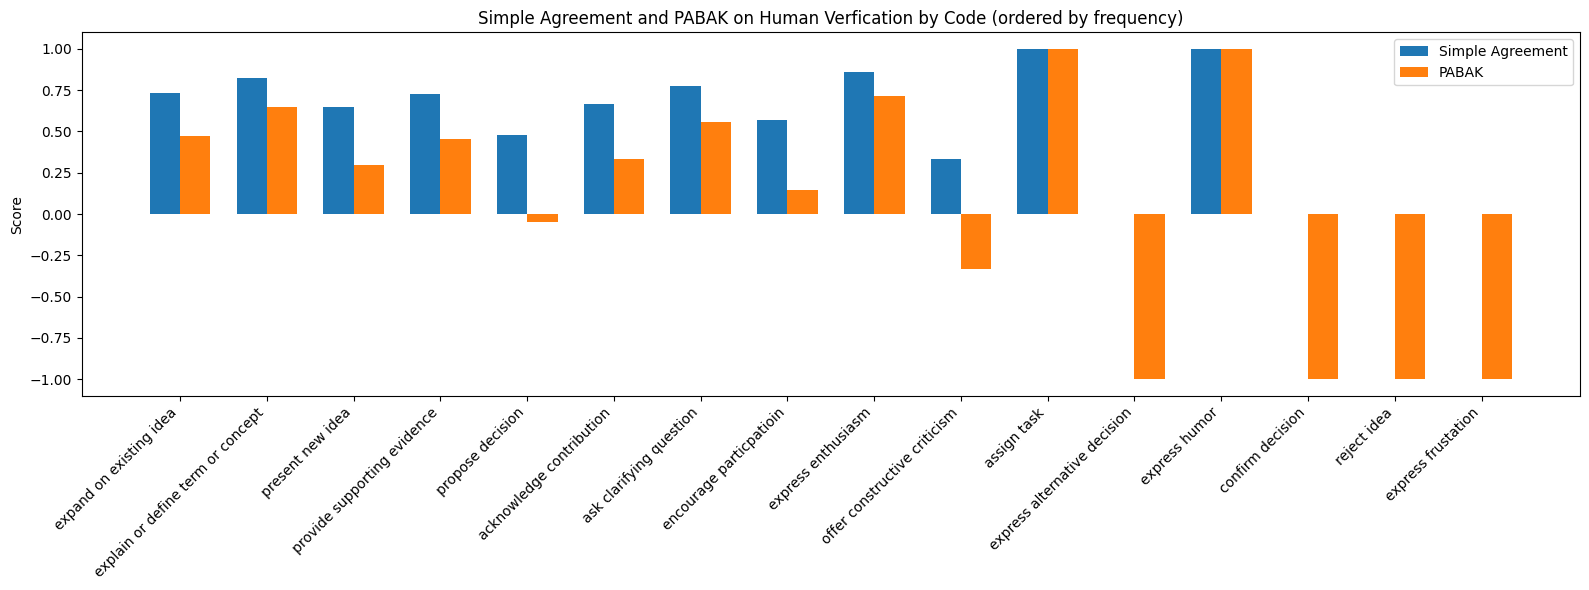

In [ ]:
# Count frequency of each code in ai_ann_df
code_freq = ai_ann_df['ai_code'].value_counts()

# Reindex scores_table to match frequency order
ordered_codes = code_freq.index.tolist()
scores_table_ordered = scores_table.set_index('Code').loc[ordered_codes].reset_index()

codes = scores_table_ordered['Code']
simple_agreement = scores_table_ordered['Simple Agreement']
pabak = scores_table_ordered['PABAK']

x = range(len(codes))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x, simple_agreement, width, label='Simple Agreement')
ax.bar([i + width for i in x], pabak, width, label='PABAK')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Simple Agreement and PABAK on Human Verfication by Code (ordered by frequency)')
ax.legend()
plt.tight_layout()
plt.show()

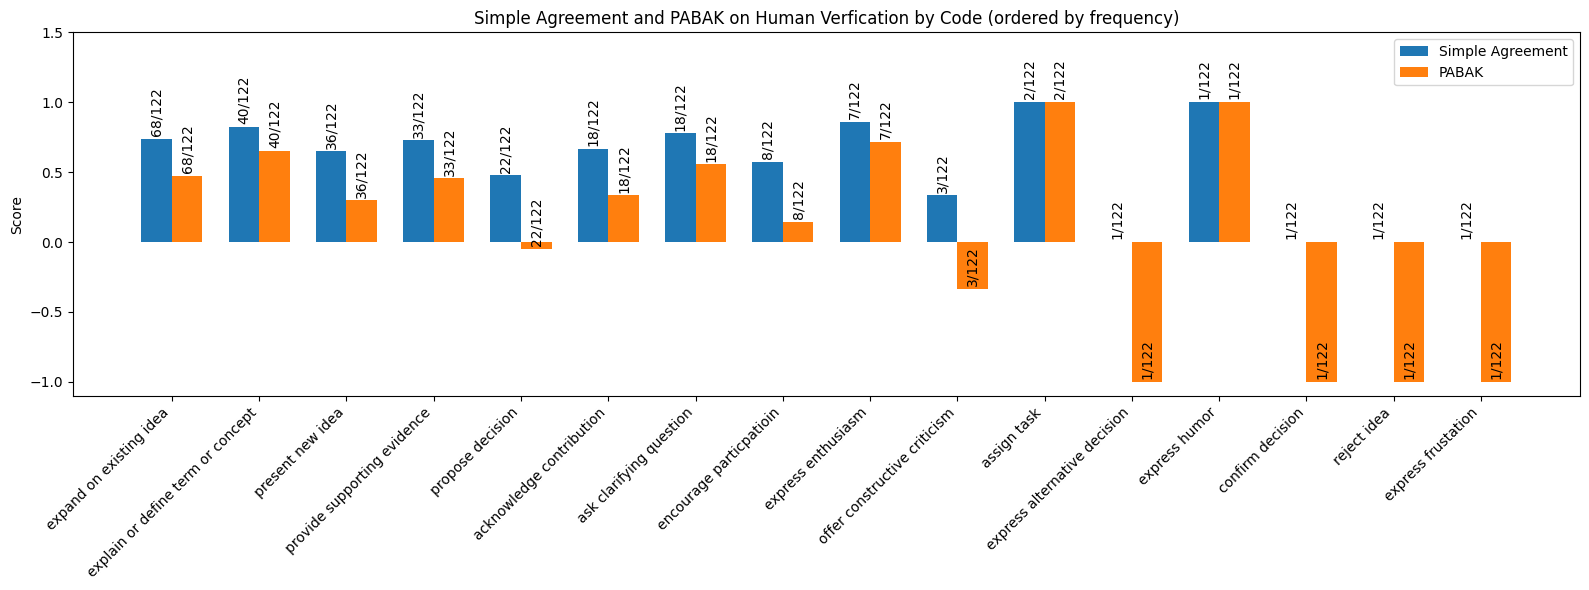

<Figure size 640x480 with 0 Axes>

In [171]:
# Calculate total unique (file, timestamp) pairs
total_file_ts = ai_ann_df[['file', 'timestamp']].drop_duplicates().shape[0]

# Calculate unique (file, timestamp) pairs for each code (across all raters)
code_file_ts_counts = {}
for code in codes:
    count = ai_ann_df[ai_ann_df['ai_code'] == code][['file', 'timestamp']].drop_duplicates().shape[0]
    code_file_ts_counts[code] = count


scores_table_ordered = scores_table.set_index('Code').loc[ordered_codes].reset_index()

codes = scores_table_ordered['Code']
simple_agreement = scores_table_ordered['Simple Agreement']
pabak = scores_table_ordered['PABAK']

x = range(len(codes))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x, simple_agreement, width, label='Simple Agreement')
ax.bar([i + width for i in x], pabak, width, label='PABAK')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_ylim(top=1.5)
ax.set_title('Simple Agreement and PABAK on Human Verfication by Code (ordered by frequency)')
ax.legend()

# Annotate each bar with count/total_file_ts
for i, code in enumerate(codes):
    count = code_file_ts_counts[code]
    # Annotate Simple Agreement bar
    ax.text(i, simple_agreement.iloc[i] + 0.02, f"{count}/{total_file_ts}", 
            ha='center', va='bottom', fontsize=10, color='black', rotation=90)
    # Annotate PABAK bar
    ax.text(i + width, pabak.iloc[i] + 0.02, f"{count}/{total_file_ts}", 
            ha='center', va='bottom', fontsize=10, color='black', rotation=90)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [ ]:
# Count rows where both ev_vf and mx_vf are 'Disagree'
both_disagree = ai_ann_df[(ai_ann_df['ev_vf'] == 'Disagree') & (ai_ann_df['mx_vf'] == 'Disagree')]
num_both_disagree = len(both_disagree)
total_rows = len(ai_ann_df)
percentage = (num_both_disagree / total_rows) * 100 if total_rows > 0 else 0

print(f"Number of rows where both ev_vf and mx_vf are 'Disagree': {num_both_disagree}")
print(f"Percentage of such rows: {percentage:.2f}%")
both_disagree.to_excel('both_disagree.xlsx', index=False)

Number of rows where both ev_vf and mx_vf are 'Disagree': 7
Percentage of such rows: 2.66%


In [ ]:
# Find codes with simple agreement score equal to zero
zero_agreement_codes = [code for code, score in simple_agreement.items() if score <= 0.6]

# Filter ai_ann_df for those codes
zero_agreement_rows = ai_ann_df[ai_ann_df['ai_code'].isin(zero_agreement_codes)]
zero_agreement_rows.to_excel('low_agreement_rows.xlsx', index=False)

In [ ]:
# Count rows where either ev_vf or mx_vf is 'Disagree'
either_disagree = ai_ann_df[(ai_ann_df['ev_vf'] == 'Disagree') | (ai_ann_df['mx_vf'] == 'Disagree')]
num_either_disagree = len(either_disagree)
total_rows = len(ai_ann_df)
percentage = (num_either_disagree / total_rows) * 100 if total_rows > 0 else 0

print(f"Number of rows where either ev_vf and mx_vf are 'Disagree': {num_either_disagree}")
print(f"Percentage of such rows: {percentage:.2f}%")
either_disagree.to_excel('either_disagree.xlsx', index=False)

Number of rows where either ev_vf and mx_vf are 'Disagree': 50
Percentage of such rows: 19.01%


### Check agreements on annotations

In [64]:
from sklearn.metrics import confusion_matrix
import numpy as np


def pabak_from_confmat(cm):
    # cm: confusion matrix [[TN, FP], [FN, TP]]
    total = cm.sum()
    a = cm[0, 0]   
    b = cm[0, 1] 
    c = cm[1, 0] 
    d = cm[1, 1]

    BI = (b-c)/total
    PI = (a-d)/total
    if total == 0:
        return np.nan
    observed_agreement = (a+d) / total
    pabak = 2 * observed_agreement - 1
    k = (pabak - PI**2 + BI**2) / (1 - PI**2 + BI**2)
    return BI, PI, pabak, k

In [37]:
ev_df = pd.read_csv('data/ev-annotation.csv')
mx_df = pd.read_csv('data/mx-annotation.csv')
gm_df = pd.read_csv('data/gemini-coding.csv')

In [38]:
import ast

rows = []
for idx, row in gm_df.iterrows():
    ann = row['annotations']
    # Handle both dict and list of dicts, and skip NaN
    if pd.isna(ann):
        continue
    # Convert string representation to dict/list if necessary
    if isinstance(ann, str):
        try:
            ann = ast.literal_eval(ann)
        except Exception:
            continue
    if isinstance(ann, dict):
        ann_items = ann.items()
    elif isinstance(ann, list):
        ann_items = []
        for d in ann:
            if isinstance(d, dict):
                ann_items.extend(d.items())
    else:
        continue
    for key, value in ann_items:
        if key == 'summarize key ideas':
            # Skip this key as per the requirement
            continue
        # print(f"Processing annotation: {key} with value: {value}")
        rows.append({
            'folder': row['folder'],
            'file': row['file'],
            'timestamp': row['timestamp'],
            'speaker': row['speaker'],
            'coder': 'gemini',
            'code': key,
            'explanation': value
        })

ai_ann_df = pd.DataFrame(rows, columns=['folder', 'file', 'timestamp', 'speaker', 'coder', 'code', 'explanation'])

In [39]:
all_ann_df = ai_ann_df.copy()

def add_coder_rows(source_df, coder_label):
    new_rows = []
    for _, row in source_df.iterrows():
        for num in range(1, 5):
            code_col = f'c{num}'
            exp_col = f'c{num}-ep' if f'c{num}-ep' in row else f'c{num}-ep'
            code = row.get(code_col, None)
            exp = row.get(exp_col, None)
            if pd.notna(code) and code != "":
                # Find file from all_ann_df with same timestamp and speaker
                match = all_ann_df[(all_ann_df['timestamp'] == row['timestamp']) & (all_ann_df['speaker'] == row['speaker'])]
                file_val = match['file'].iloc[0] if not match.empty else None
                if code == "NA (please provide explanation)":
                    continue
                new_rows.append({
                    'folder': None,
                    'file': file_val,
                    'timestamp': row['timestamp'],
                    'speaker': row['speaker'],
                    'coder': coder_label,
                    'code': code,
                    'explanation': exp,
                    'notes': row['notes']
                })
    return new_rows

ev_rows = add_coder_rows(ev_df, 'ev')
mx_rows = add_coder_rows(mx_df, 'mx')

# Append to all_ann_df
all_ann_df = pd.concat([all_ann_df, pd.DataFrame(ev_rows + mx_rows)], ignore_index=True)

In [40]:
print("Number of rows where coder == 'gemini':", (all_ann_df['coder'] == 'gemini').sum())
print("Number of rows where coder == 'ev':", (all_ann_df['coder'] == 'ev').sum())
print("Number of rows where coder == 'mx':", (all_ann_df['coder'] == 'mx').sum())

Number of rows where coder == 'gemini': 330
Number of rows where coder == 'ev': 229
Number of rows where coder == 'mx': 184


In [33]:
def create_unique_ids_for_combination(df, id_columns=['file', 'timestamp', 'speaker'], id_column_name='id'):
    composite_key = df[id_columns].astype(str).agg('_'.join, axis=1)
    unique_combinations = composite_key.unique()
    id_mapping = {combo: idx for idx, combo in enumerate(unique_combinations)}
    df_copy = df.copy()
    df_copy[id_column_name] = composite_key.map(id_mapping)
    return df_copy

In [41]:
all_ann_df = create_unique_ids_for_combination(all_ann_df, ['file', 'timestamp', 'speaker'])

In [42]:
print("Number of unique values in all_ann_df['id']:", all_ann_df['id'].nunique())
print("Number of rows in ev_df:", len(ev_df))
print("Number of rows in mx_df:", len(mx_df))
print("Number of rows in gm_df:", len(gm_df))

Number of unique values in all_ann_df['id']: 155
Number of rows in ev_df: 129
Number of rows in mx_df: 138
Number of rows in gm_df: 157


In [43]:
# Filter out ids where there are no rows with coder == 'ev' because there were some videos that were not watched by the human coders

ids_with_ev = all_ann_df[all_ann_df['coder'] == 'ev']['id'].unique()
filtered_ann_df = all_ann_df[all_ann_df['id'].isin(ids_with_ev)].copy()
num_missing_ids = len(set(all_ann_df['id']) - set(filtered_ann_df['id']))
print(f"Number of ids in all_ann_df but not in filtered_ann_df: {num_missing_ids}")

Number of ids in all_ann_df but not in filtered_ann_df: 38


### create a csv file to compare annotations

In [44]:
print(filtered_ann_df.head())

                             folder  \
0  2021MND/output_2021_04_22_MND_S6   
1  2021MND/output_2021_04_22_MND_S6   
2  2021MND/output_2021_04_22_MND_S6   
3  2021MND/output_2021_04_22_MND_S6   
4  2021MND/output_2021_04_22_MND_S6   

                                                file      timestamp  \
0  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    00:28-00:44   
1  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    03:00-03:34   
2  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    03:00-03:34   
3  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...  [07:44-08:47]   
4  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...  [07:44-08:47]   

                speaker   coder                               code  \
0         Nandita Garud  gemini           acknowledge contribution   
1            Mark Mimee  gemini  explain or define term or concept   
2            Mark Mimee  gemini                   present new idea   
3  Dr. Ali Keshavarzian  gemini        provide supporting 

In [45]:
filtered_ann_df.to_excel('all_annotations.xlsx', index=False)

### agreement between evey and max

In [120]:
evmx_pabak = {}

all_ids = filtered_ann_df['id'].unique()
all_codes = filtered_ann_df['code'].unique()

for code in all_codes:
    y_ev = []
    y_mx = []
    for id_ in all_ids:
        # For each coder, does this id have this code?
        ev_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)).any()
        mx_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)).any()
        y_ev.append(int(ev_has))
        y_mx.append(int(mx_has))
    # Now y_ev and y_mx are binary vectors for this code
    cm = confusion_matrix(y_ev, y_mx, labels=[0,1])
    bi, pi, pabak, k = pabak_from_confmat(cm)
    evmx_pabak[code] = [bi, pi, pabak, k] 

for code, values in evmx_pabak.items():
    print(f"PABAK for code '{code}': {values[2]:.3f}")
    print(f"K for code '{code}': {values[3]:.3f}")

PABAK for code 'acknowledge contribution': 0.366
K for code 'acknowledge contribution': 0.301
PABAK for code 'explain or define term or concept': 0.268
K for code 'explain or define term or concept': 0.300
PABAK for code 'present new idea': -0.024
K for code 'present new idea': -0.114
PABAK for code 'provide supporting evidence': 0.268
K for code 'provide supporting evidence': 0.322
PABAK for code 'propose decision': 0.317
K for code 'propose decision': 0.196
PABAK for code 'ask clarifying question': 0.317
K for code 'ask clarifying question': 0.293
PABAK for code 'expand on existing idea': 0.171
K for code 'expand on existing idea': 0.028
PABAK for code 'express enthusiasm': 0.366
K for code 'express enthusiasm': -0.177
PABAK for code 'encourage particpatioin': 0.561
K for code 'encourage particpatioin': 0.272
PABAK for code 'express agreement': 0.707
K for code 'express agreement': 0.534
PABAK for code 'express alternative decision': 0.805
K for code 'express alternative decision': -

/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_4536/2517105094.py:19: RuntimeWarning: invalid value encountered in scalar divide
  k = (pabak - PI**2 + BI**2) / (1 - PI**2 + BI**2)


#### agreement between ev and gemini

In [121]:
evgm_pabak = {}

for code in all_codes:
    y_ev = []
    y_gm = []
    for id_ in all_ids:
        # For each coder, does this id have this code?
        ev_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)).any()
        gm_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)).any()
        y_ev.append(int(ev_has))
        y_gm.append(int(gm_has))
    # Now y_ev and y_mx are binary vectors for this code
    cm = confusion_matrix(y_ev, y_gm, labels=[0,1])
    bi, pi, pabak, k = pabak_from_confmat(cm)
    evgm_pabak[code] = [bi, pi, pabak, k] 

for code, values in evgm_pabak.items():
    print(f"PABAK for code '{code}': {values[2]:.3f}")
    print(f"K for code '{code}': {values[3]:.3f}")

PABAK for code 'acknowledge contribution': 0.463
K for code 'acknowledge contribution': 0.445
PABAK for code 'explain or define term or concept': 0.268
K for code 'explain or define term or concept': 0.240
PABAK for code 'present new idea': -0.024
K for code 'present new idea': 0.097
PABAK for code 'provide supporting evidence': 0.317
K for code 'provide supporting evidence': 0.320
PABAK for code 'propose decision': 0.756
K for code 'propose decision': 0.733
PABAK for code 'ask clarifying question': 0.610
K for code 'ask clarifying question': 0.530
PABAK for code 'expand on existing idea': 0.463
K for code 'expand on existing idea': 0.347
PABAK for code 'express enthusiasm': 0.317
K for code 'express enthusiasm': -0.087
PABAK for code 'encourage particpatioin': 0.610
K for code 'encourage particpatioin': 0.381
PABAK for code 'express agreement': 0.659
K for code 'express agreement': 0.481
PABAK for code 'express alternative decision': 0.805
K for code 'express alternative decision': -0

#### agreement between max and gemini

In [122]:
mxgm_pabak = {}

for code in all_codes:
    y_mx = []
    y_gm = []
    for id_ in all_ids:
        # For each coder, does this id have this code?
        mx_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)).any()
        gm_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)).any()
        y_mx.append(int(mx_has))
        y_gm.append(int(gm_has))
    # Now y_ev and y_mx are binary vectors for this code
    cm = confusion_matrix(y_mx, y_gm, labels=[0,1])
    bi, pi, pabak, k = pabak_from_confmat(cm)
    mxgm_pabak[code] = [bi, pi, pabak, k] 

for code, values in mxgm_pabak.items():
    print(f"PABAK for code '{code}': {values[2]:.3f}")
    print(f"K for code '{code}': {values[3]:.3f}")

PABAK for code 'acknowledge contribution': 0.317
K for code 'acknowledge contribution': 0.143
PABAK for code 'explain or define term or concept': -0.073
K for code 'explain or define term or concept': -0.013
PABAK for code 'present new idea': -0.171
K for code 'present new idea': -0.084
PABAK for code 'provide supporting evidence': 0.171
K for code 'provide supporting evidence': 0.161
PABAK for code 'propose decision': 0.268
K for code 'propose decision': 0.110
PABAK for code 'ask clarifying question': 0.317
K for code 'ask clarifying question': 0.298
PABAK for code 'expand on existing idea': 0.317
K for code 'expand on existing idea': 0.077
PABAK for code 'express enthusiasm': 0.561
K for code 'express enthusiasm': 0.185
PABAK for code 'encourage particpatioin': 0.756
K for code 'encourage particpatioin': 0.543
PABAK for code 'express agreement': 0.854
K for code 'express agreement': 0.778
PABAK for code 'express alternative decision': 0.902
K for code 'express alternative decision': 

In [100]:
ai_vs_human_union_pabak = {}

for code in all_codes:
    y_human = []
    y_gm = []
    for id_ in all_ids:
        # Human union: 1 if either ev or mx assigned this code to this id
        ev_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)).any()
        mx_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)).any()
        human_has = ev_has or mx_has
        gm_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)).any()
        y_human.append(int(human_has))
        y_gm.append(int(gm_has))
    cm = confusion_matrix(y_human, y_gm, labels=[0,1])
    bi, pi, k = pabak_from_confmat(cm)
    ai_vs_human_union_pabak[code] = [bi, pi, k]

for code, values in ai_vs_human_union_pabak.items():
    print(f"PABAK for code '{code}' (AI vs. human union): {values[2]:.3f}")
    print(f"BI for code '{code}': {values[0]:.3f}")
    print(f"PI for code '{code}': {values[1]:.3f}")

PABAK for code 'provide supporting evidence' (AI vs. human union): 0.369
BI for code 'provide supporting evidence': -0.122
PI for code 'provide supporting evidence': -0.098
PABAK for code 'ask clarifying question' (AI vs. human union): 0.287
BI for code 'ask clarifying question': -0.220
PI for code 'ask clarifying question': 0.146
PABAK for code 'express alternative decision' (AI vs. human union): -0.041
BI for code 'express alternative decision': -0.073
PI for code 'express alternative decision': 0.878
PABAK for code 'assign task' (AI vs. human union): 0.655
BI for code 'assign task': 0.024
PI for code 'assign task': 0.927
PABAK for code 'expand on existing idea' (AI vs. human union): 0.377
BI for code 'expand on existing idea': -0.122
PI for code 'expand on existing idea': -0.683
PABAK for code 'explain or define term or concept' (AI vs. human union): 0.161
BI for code 'explain or define term or concept': -0.049
PI for code 'explain or define term or concept': -0.268
PABAK for code '

In [123]:
import pandas as pd
import numpy as np

# Collect all unique codes from the three dictionaries
all_codes = set(evmx_pabak.keys()) | set(evgm_pabak.keys()) | set(mxgm_pabak.keys())

# Build the table
pabak_table = pd.DataFrame({
    'Code': list(all_codes),
    'ev-mx': [evmx_pabak.get(code, [np.nan, np.nan, np.nan, np.nan])[2] for code in all_codes],
    'ev-ai': [evgm_pabak.get(code, [np.nan, np.nan, np.nan, np.nan])[2] for code in all_codes],
    'mx-ai': [mxgm_pabak.get(code, [np.nan, np.nan, np.nan, np.nan])[2] for code in all_codes]
})

# Style the table with a diverging colormap
styled_pabak = pabak_table.set_index('Code').style.background_gradient(
    cmap='RdYlGn', axis=None, vmin=-1, vmax=1
).format("{:.3f}")

styled_pabak

,ev-mx,ev-ai,mx-ai
Code,,,
provide supporting evidence,0.268,0.317,0.171
ask clarifying question,0.317,0.610,0.317
express alternative decision,0.805,0.805,0.902
assign task,0.951,0.902,0.951
expand on existing idea,0.171,0.463,0.317
explain or define term or concept,0.268,0.268,-0.073
express agreement,0.707,0.659,0.854
confirm decision,1.000,0.951,0.951
present new idea,-0.024,-0.024,-0.171


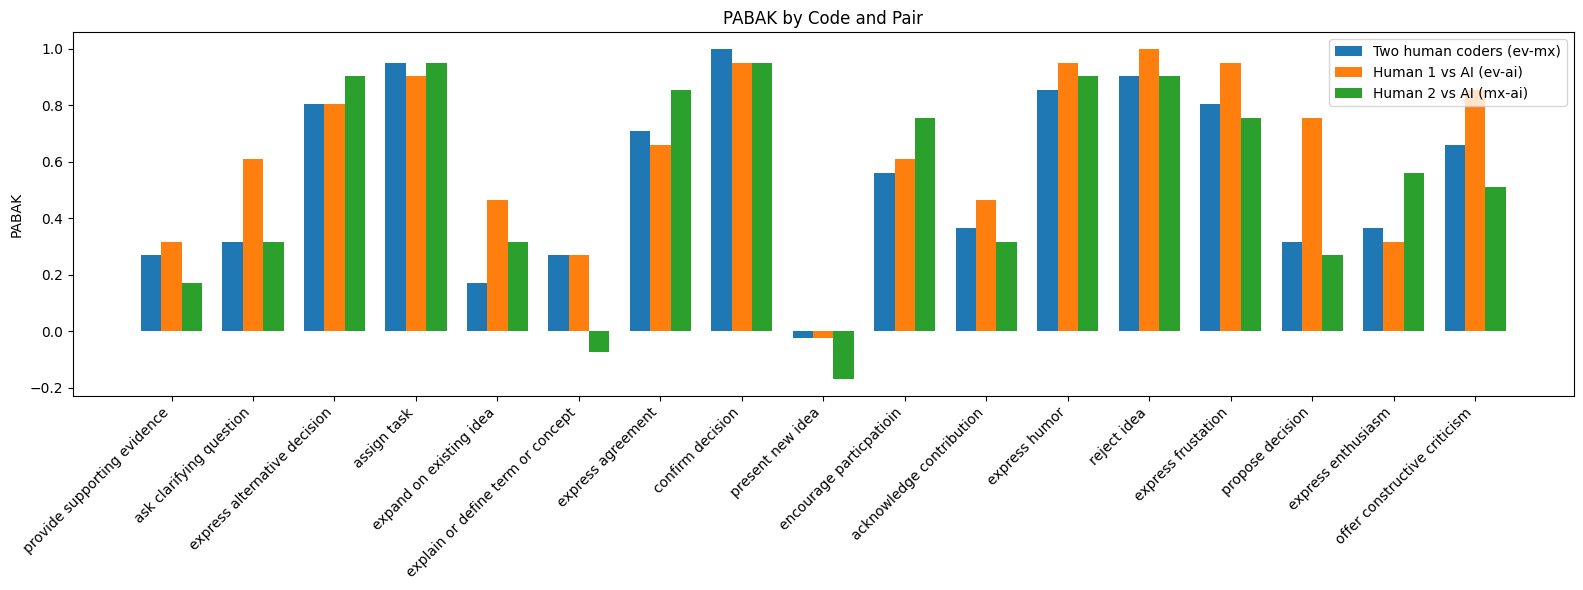

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
codes = pabak_table['Code']
ev_mx = pabak_table['ev-mx']
ev_ai = pabak_table['ev-ai']
mx_ai = pabak_table['mx-ai']

x = np.arange(len(codes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6)) 

bar1 = ax.bar(x - width, ev_mx, width, label='Two human coders (ev-mx)')
bar2 = ax.bar(x, ev_ai, width, label='Human 1 vs AI (ev-ai)')
bar3 = ax.bar(x + width, mx_ai, width, label='Human 2 vs AI (mx-ai)')

ax.set_xticks(x)
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('PABAK')
ax.set_title('PABAK by Code and Pair')
ax.legend()
plt.tight_layout()
plt.show()

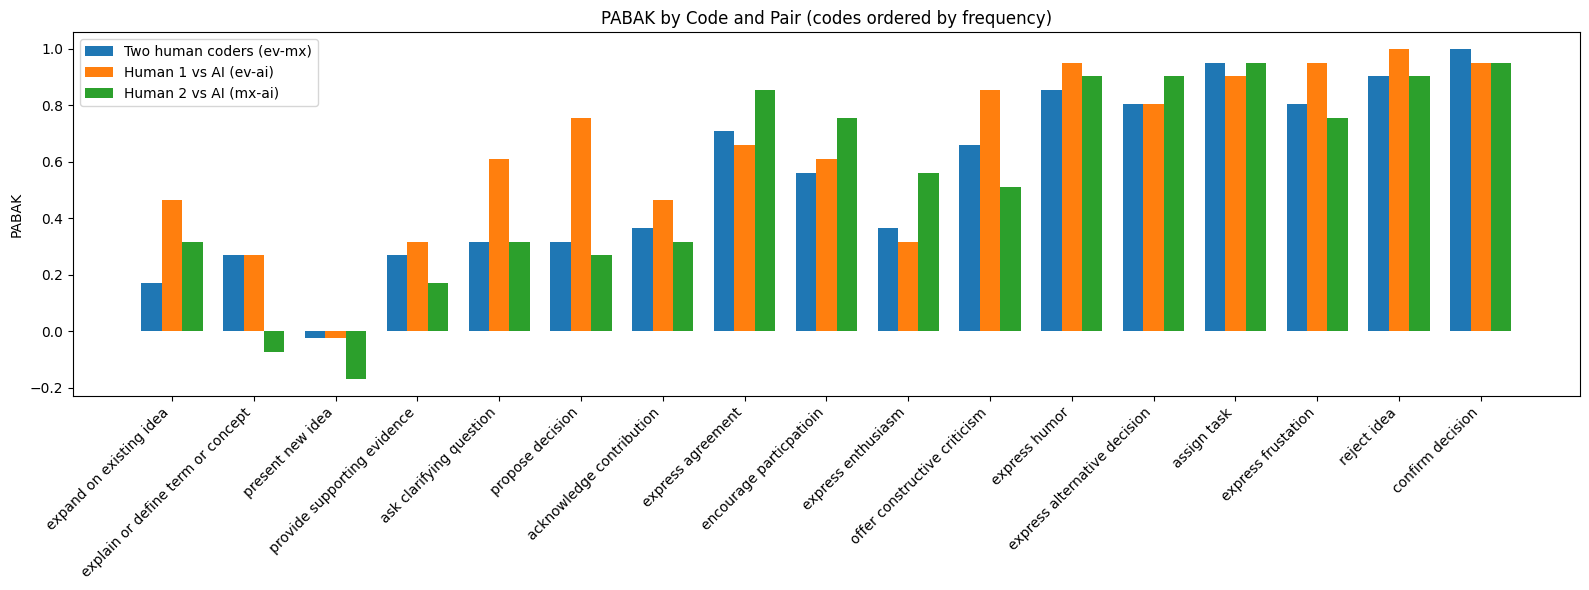

In [ ]:
# Order codes by frequency in filtered_ann_df
code_freq = filtered_ann_df['code'].value_counts()
ordered_codes = code_freq.index.tolist()

# Reindex pabak_table to match this order
pabak_table_ordered = pabak_table.set_index('Code').loc[ordered_codes].reset_index()

codes = pabak_table_ordered['Code']
ev_mx = pabak_table_ordered['ev-mx']
ev_ai = pabak_table_ordered['ev-ai']
mx_ai = pabak_table_ordered['mx-ai']

x = np.arange(len(codes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6)) 

bar1 = ax.bar(x - width, ev_mx, width, label='Two human coders (ev-mx)')
bar2 = ax.bar(x, ev_ai, width, label='Human 1 vs AI (ev-ai)')
bar3 = ax.bar(x + width, mx_ai, width, label='Human 2 vs AI (mx-ai)')

ax.set_xticks(x)
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('PABAK')
ax.set_title('PABAK by Code and Pair (codes ordered by frequency)')
ax.legend()
plt.tight_layout()
plt.show()

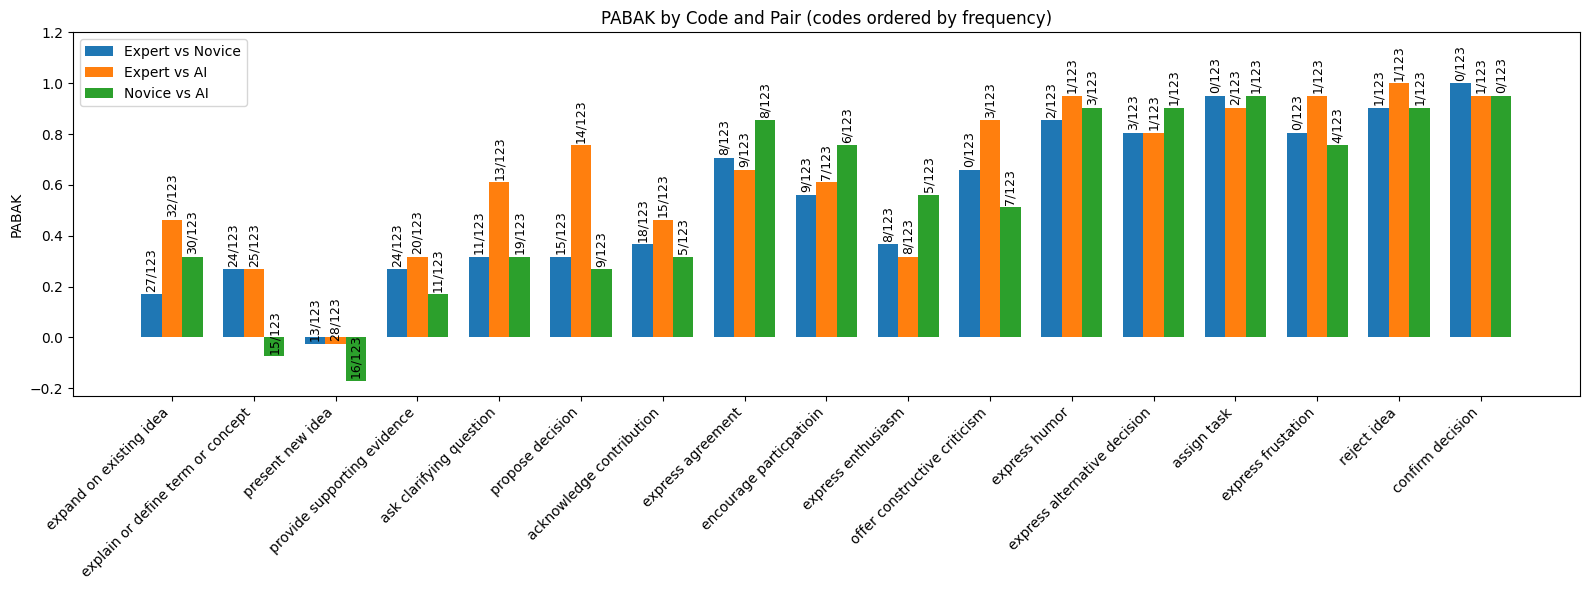

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
codes = pabak_table_ordered['Code']
ev_mx = pabak_table_ordered['ev-mx']
ev_ai = pabak_table_ordered['ev-ai']
mx_ai = pabak_table_ordered['mx-ai']

x = np.arange(len(codes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6)) 

# Calculate counts for each code and rater
ev_counts = []
mx_counts = []
ai_counts = []
total_ids = filtered_ann_df[['id', 'timestamp']].drop_duplicates().shape[0]

for code in codes:
    ev_count = filtered_ann_df[(filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)]['id'].nunique()
    mx_count = filtered_ann_df[(filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)]['id'].nunique()
    ai_count = filtered_ann_df[(filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)]['id'].nunique()
    ev_counts.append(ev_count)
    mx_counts.append(mx_count)
    ai_counts.append(ai_count)

# Plot bars
bar1 = ax.bar(x - width, ev_mx, width, label='Expert vs Novice')
bar2 = ax.bar(x, ev_ai, width, label='Expert vs AI')
bar3 = ax.bar(x + width, mx_ai, width, label='Novice vs AI')

# Annotate bars with counts
for i in range(len(codes)):
    # ev-mx bar
    ax.text(x[i] - width, ev_mx[i] + 0.01, f"{ev_counts[i]}/{total_ids}", ha='center', va='bottom', fontsize=9, rotation=90)
    # ev-ai bar
    ax.text(x[i], ev_ai[i] + 0.01, f"{ai_counts[i]}/{total_ids}", ha='center', va='bottom', fontsize=9, rotation=90)
    # mx-ai bar
    ax.text(x[i] + width, mx_ai[i] + 0.01, f"{mx_counts[i]}/{total_ids}", ha='center', va='bottom', fontsize=9, rotation=90)

ax.set_xticks(x)
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('PABAK')
max_height = max(max(ev_mx), max(ev_ai), max(mx_ai))
ax.set_ylim(top=max_height + 0.2)
ax.set_title('PABAK by Code and Pair (codes ordered by frequency)')
ax.legend()
plt.tight_layout()
plt.show()

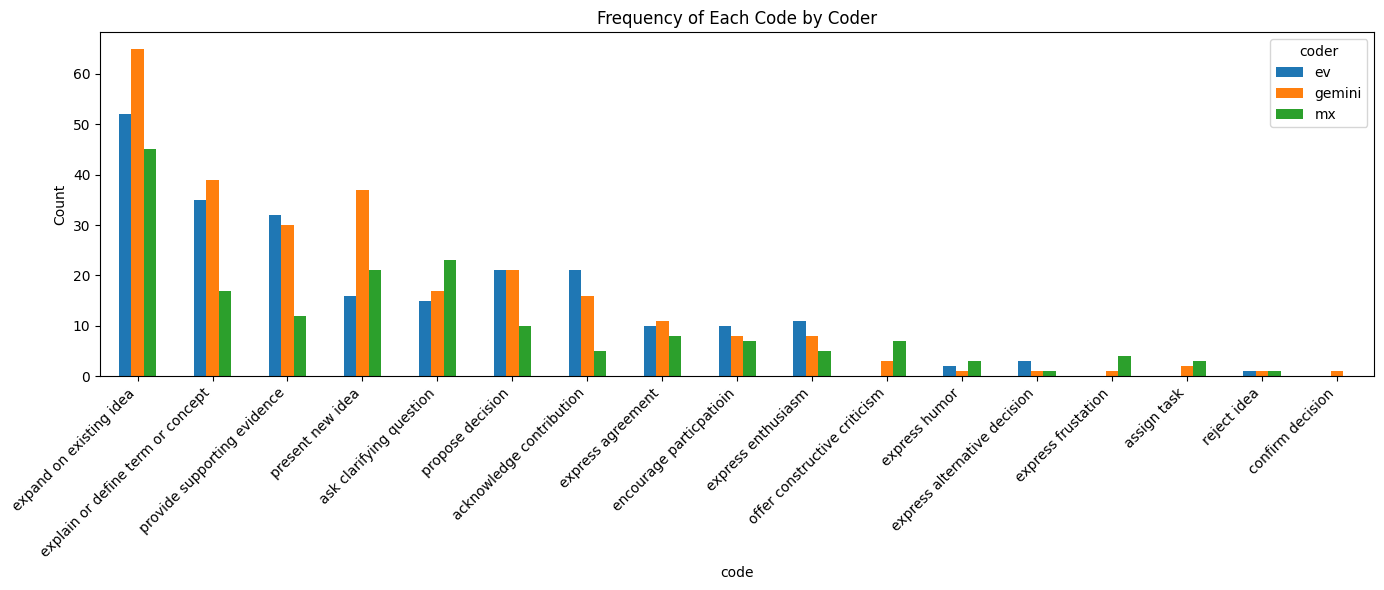

In [108]:
import matplotlib.pyplot as plt

# Count how often each code is used by each coder
code_counts = filtered_ann_df.groupby(['coder', 'code']).size().unstack(fill_value=0)

# Rank codes by total count (sum across coders)
code_order = code_counts.sum(axis=0).sort_values(ascending=False).index

# Plot with ranked codes
ax = code_counts[code_order].T.plot(kind='bar', figsize=(14, 6))
ax.set_ylabel('Count')
ax.set_title('Frequency of Each Code by Coder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### investigate differences in agreements

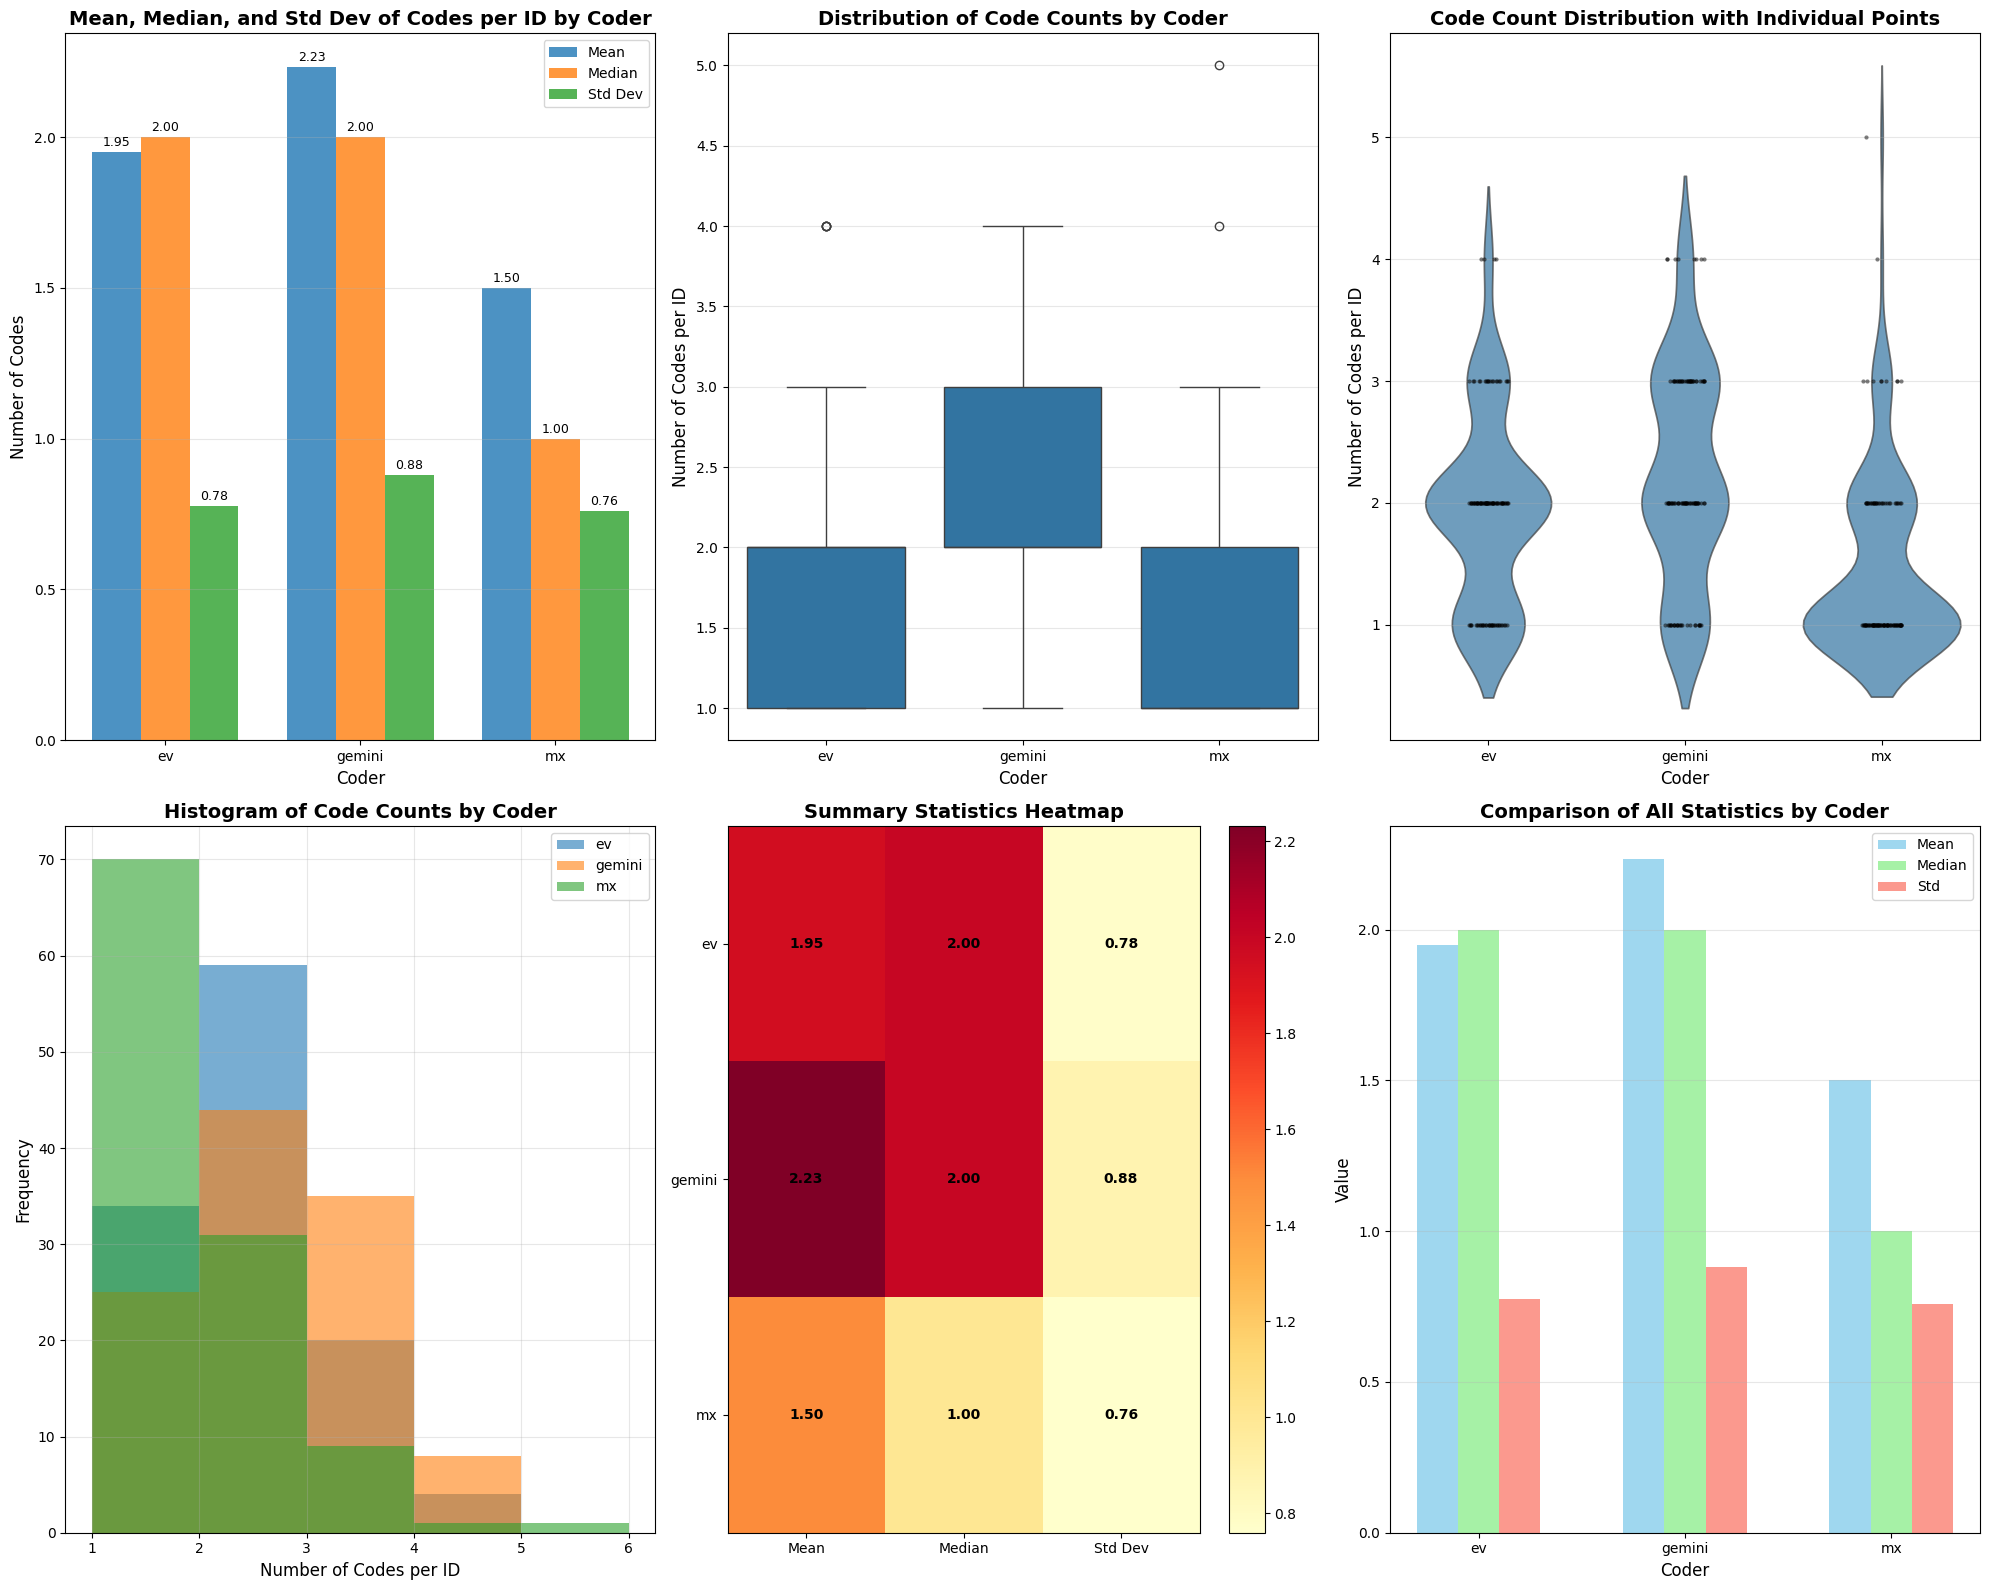

,Coder,Mean,Median,Std Dev,Count
0,ev,1.948718,2.0,0.775110,117
1,gemini,2.232143,2.0,0.880030,112
2,mx,1.500000,1.0,0.759326,112


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_coder_patterns(df, id_column='id', coder_column='coder', code_column='code'):
    # Group by ID and coder, count unique codes
    code_counts = df.groupby([id_column, coder_column])[code_column].nunique().reset_index()
    code_counts.columns = [id_column, coder_column, 'num_codes']
    
    # Calculate statistics for each coder
    coder_stats = {}
    for coder in code_counts[coder_column].unique():
        coder_data = code_counts[code_counts[coder_column] == coder]['num_codes']
        coder_stats[coder] = {
            'mean': coder_data.mean(),
            'median': coder_data.median(),
            'std': coder_data.std(),
            'min': coder_data.min(),
            'max': coder_data.max(),
            'count': len(coder_data)
        }
    
    return coder_stats, code_counts

def plot_coder_patterns(coder_stats, code_counts, coder_column='coder', save_plots=False):
    """
    Create comprehensive visualizations of coder patterns.
    
    Parameters:
    -----------
    coder_stats : dict
        Statistics for each coder
    code_counts : pandas DataFrame
        DataFrame with code counts per ID and coder
    save_plots : bool
        Whether to save plots to files
    """
    
    # Set up the plotting style
    plt.style.use('default')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Bar plot of mean, median, and std for each coder
    plt.subplot(2, 3, 1)
    coders = list(coder_stats.keys())
    means = [coder_stats[coder]['mean'] for coder in coders]
    medians = [coder_stats[coder]['median'] for coder in coders]
    stds = [coder_stats[coder]['std'] for coder in coders]
    
    x = np.arange(len(coders))
    width = 0.25
    
    bars1 = plt.bar(x - width, means, width, label='Mean', alpha=0.8)
    bars2 = plt.bar(x, medians, width, label='Median', alpha=0.8)
    bars3 = plt.bar(x + width, stds, width, label='Std Dev', alpha=0.8)
    
    plt.xlabel('Coder', fontsize=12)
    plt.ylabel('Number of Codes', fontsize=12)
    plt.title('Mean, Median, and Std Dev of Codes per ID by Coder', fontsize=14, fontweight='bold')
    plt.xticks(x, coders)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # 2. Box plot of code counts by coder
    plt.subplot(2, 3, 2)
    sns.boxplot(data=code_counts, x=coder_column, y='num_codes')
    plt.xlabel('Coder', fontsize=12)
    plt.ylabel('Number of Codes per ID', fontsize=12)
    plt.title('Distribution of Code Counts by Coder', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Violin plot with individual points
    plt.subplot(2, 3, 3)
    sns.violinplot(data=code_counts, x=coder_column, y='num_codes', inner=None, alpha=0.7)
    sns.stripplot(data=code_counts, x=coder_column, y='num_codes', color='black', alpha=0.5, size=3)
    plt.xlabel('Coder', fontsize=12)
    plt.ylabel('Number of Codes per ID', fontsize=12)
    plt.title('Code Count Distribution with Individual Points', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # 4. Histogram of code counts by coder
    plt.subplot(2, 3, 4)
    for coder in code_counts[coder_column].unique():
        coder_data = code_counts[code_counts[coder_column] == coder]['num_codes']
        plt.hist(coder_data, alpha=0.6, label=coder, bins=range(1, int(coder_data.max()) + 2))
    
    plt.xlabel('Number of Codes per ID', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of Code Counts by Coder', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 5. Summary statistics table visualization
    plt.subplot(2, 3, 5)
    # Create a table-like visualization
    stats_data = []
    for coder in coders:
        stats = coder_stats[coder]
        stats_data.append([coder, stats['mean'], stats['median'], stats['std'], stats['count']])
    
    stats_df = pd.DataFrame(stats_data, columns=['Coder', 'Mean', 'Median', 'Std Dev', 'Count'])
    
    # Create a heatmap-like visualization
    stats_matrix = stats_df[['Mean', 'Median', 'Std Dev']].values
    im = plt.imshow(stats_matrix, cmap='YlOrRd', aspect='auto')
    plt.colorbar(im)
    
    plt.xticks(range(3), ['Mean', 'Median', 'Std Dev'])
    plt.yticks(range(len(coders)), coders)
    plt.title('Summary Statistics Heatmap', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(coders)):
        for j in range(3):
            plt.text(j, i, f'{stats_matrix[i, j]:.2f}', ha='center', va='center', 
                    color='black', fontweight='bold')
    
    # 6. Comparison of coders side by side
    plt.subplot(2, 3, 6)
    # Create a grouped bar chart comparing all statistics
    x = np.arange(len(coders))
    width = 0.2
    
    metrics = ['mean', 'median', 'std']
    colors = ['skyblue', 'lightgreen', 'salmon']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        values = [coder_stats[coder][metric] for coder in coders]
        plt.bar(x + i*width, values, width, label=metric.title(), color=color, alpha=0.8)
    
    plt.xlabel('Coder', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title('Comparison of All Statistics by Coder', fontsize=14, fontweight='bold')
    plt.xticks(x + width, coders)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('coder_patterns_analysis.png', dpi=300, bbox_inches='tight')
        print("Plot saved as: coder_patterns_analysis.png")
    
    plt.show()
    
    return stats_df
# Apply to your DataFrame
coder_stats, code_counts = analyze_coder_patterns(filtered_ann_df)
plot_coder_patterns(coder_stats, code_counts, save_plots=False)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import combinations
import networkx as nx

def create_cooccurrence_matrix(df, id_column='id', coder_column='coder', code_column='code'):
    """
    Create co-occurrence matrices for each coder.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns for ID, coder, and code
    id_column : str
        Name of the column containing unique IDs
    coder_column : str
        Name of the column containing coder information
    code_column : str
        Name of the column containing codes
    
    Returns:
    --------
    dict : Dictionary of co-occurrence matrices for each coder
    """
    
    cooccurrence_matrices = {}
    
    for coder in df[coder_column].unique():
        print(f"\n=== Creating co-occurrence matrix for {coder.upper()} ===")
        
        # Get data for this coder
        coder_data = df[df[coder_column] == coder]
        
        # Get all unique codes for this coder
        all_codes = coder_data[code_column].unique()
        print(f"Number of unique codes: {len(all_codes)}")
        
        # Create co-occurrence matrix
        cooccurrence_matrix = pd.DataFrame(0, index=all_codes, columns=all_codes)
        
        # For each ID, find which codes co-occur
        for id_val in coder_data[id_column].unique():
            id_codes = set(coder_data[coder_data[id_column] == id_val][code_column])
            
            # Update co-occurrence counts
            for code1, code2 in combinations(id_codes, 2):
                cooccurrence_matrix.loc[code1, code2] += 1
                cooccurrence_matrix.loc[code2, code1] += 1
        
        cooccurrence_matrices[coder] = cooccurrence_matrix
        print(f"Matrix shape: {cooccurrence_matrix.shape}")
        
        # Show top co-occurring pairs
        print("\nTop 10 co-occurring code pairs:")
        pairs = []
        for i in range(len(all_codes)):
            for j in range(i+1, len(all_codes)):
                code1, code2 = all_codes[i], all_codes[j]
                count = cooccurrence_matrix.loc[code1, code2]
                if count > 0:
                    pairs.append((code1, code2, count))
        
        pairs.sort(key=lambda x: x[2], reverse=True)
        for code1, code2, count in pairs[:10]:
            print(f"  {code1} + {code2}: {count} times")
    
    return cooccurrence_matrices

def analyze_cooccurrence_patterns(cooccurrence_matrices):
    """
    Analyze patterns in co-occurrence matrices.
    
    Parameters:
    -----------
    cooccurrence_matrices : dict
        Dictionary of co-occurrence matrices for each coder
    """
    
    print("\n" + "=" * 80)
    print("CO-OCCURRENCE PATTERN ANALYSIS")
    print("=" * 80)
    
    # Compare co-occurrence patterns between coders
    coders = list(cooccurrence_matrices.keys())
    
    for i, coder1 in enumerate(coders):
        for coder2 in coders[i+1:]:
            print(f"\n=== Comparing {coder1.upper()} vs {coder2.upper()} ===")
            
            matrix1 = cooccurrence_matrices[coder1]
            matrix2 = cooccurrence_matrices[coder2]
            
            # Find common codes
            common_codes = set(matrix1.index) & set(matrix2.index)
            print(f"Common codes: {len(common_codes)}")
            
            if len(common_codes) > 0:
                # Compare co-occurrence patterns for common codes
                common_matrix1 = matrix1.loc[list(common_codes), list(common_codes)]
                common_matrix2 = matrix2.loc[list(common_codes), list(common_codes)]
                
                # Calculate correlation between matrices
                correlation = np.corrcoef(common_matrix1.values.flatten(), 
                                        common_matrix2.values.flatten())[0, 1]
                print(f"Correlation between co-occurrence patterns: {correlation:.3f}")
                
                # Find most different co-occurrence patterns
                differences = []
                for code1 in common_codes:
                    for code2 in common_codes:
                        if code1 != code2:
                            diff = abs(common_matrix1.loc[code1, code2] - common_matrix2.loc[code1, code2])
                            differences.append((code1, code2, diff))
                
                differences.sort(key=lambda x: x[2], reverse=True)
                print("\nTop 5 most different co-occurrence patterns:")
                for code1, code2, diff in differences[:5]:
                    val1 = common_matrix1.loc[code1, code2]
                    val2 = common_matrix2.loc[code1, code2]
                    print(f"  {code1} + {code2}: {coder1}={val1}, {coder2}={val2}, diff={diff}")

def create_cooccurrence_visualizations(cooccurrence_matrices, save_plots=True):
    """
    Create visualizations of co-occurrence patterns.
    
    Parameters:
    -----------
    cooccurrence_matrices : dict
        Dictionary of co-occurrence matrices for each coder
    save_plots : bool
        Whether to save plots to files
    """
    
    plt.style.use('default')
    sns.set_palette("husl")
    
    n_coders = len(cooccurrence_matrices)
    fig, axes = plt.subplots(2, n_coders, figsize=(6*n_coders, 12))
    
    if n_coders == 1:
        axes = axes.reshape(2, 1)
    
    for i, (coder, matrix) in enumerate(cooccurrence_matrices.items()):
        # 1. Heatmap of co-occurrence matrix
        ax1 = axes[0, i]
        sns.heatmap(matrix, annot=False, cmap='YlOrRd', ax=ax1)
        ax1.set_title(f'{coder.upper()} Co-occurrence Matrix', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Codes')
        ax1.set_ylabel('Codes')
        
        # 2. Network graph of top co-occurrences
        ax2 = axes[1, i]
        create_network_graph(matrix, ax2, coder, top_n=10)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('code_cooccurrence_analysis.png', dpi=300, bbox_inches='tight')
        print("Plot saved as: code_cooccurrence_analysis.png")
    
    plt.show()

def create_network_graph(matrix, ax, coder, top_n=10):
    """
    Create a network graph showing code co-occurrences.
    
    Parameters:
    -----------
    matrix : pandas DataFrame
        Co-occurrence matrix
    ax : matplotlib axis
        Axis to plot on
    coder : str
        Name of the coder
    top_n : int
        Number of top co-occurrences to show
    """
    
    # Create graph
    G = nx.Graph()
    
    # Add edges for top co-occurrences
    edges = []
    for i in range(len(matrix.index)):
        for j in range(i+1, len(matrix.columns)):
            code1, code2 = matrix.index[i], matrix.columns[j]
            weight = matrix.loc[code1, code2]
            if weight > 0:
                edges.append((code1, code2, weight))
    
    edges.sort(key=lambda x: x[2], reverse=True)
    
    # Add top edges to graph
    for code1, code2, weight in edges[:top_n]:
        G.add_edge(code1, code2, weight=weight)
    
    if len(G.edges()) > 0:
        # Draw network
        pos = nx.spring_layout(G, k=1, iterations=50)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                              node_size=1000, ax=ax)
        
        # Draw edges with thickness based on weight
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        max_weight = max(edge_weights) if edge_weights else 1
        edge_widths = [w/max_weight * 3 for w in edge_weights]
        
        nx.draw_networkx_edges(G, pos, width=edge_widths, 
                              edge_color='gray', alpha=0.7, ax=ax)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
        
        ax.set_title(f'{coder.upper()} Code Network\n(Top {top_n} co-occurrences)', 
                    fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No co-occurrences\nfound', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{coder.upper()} Code Network', fontsize=12, fontweight='bold')
    
    ax.axis('off')

def calculate_cooccurrence_similarity(cooccurrence_matrices):
    """
    Calculate similarity between co-occurrence patterns of different coders.
    
    Parameters:
    -----------
    cooccurrence_matrices : dict
        Dictionary of co-occurrence matrices for each coder
    
    Returns:
    --------
    pandas DataFrame : Similarity matrix
    """
    
    coders = list(cooccurrence_matrices.keys())
    similarity_matrix = pd.DataFrame(0, index=coders, columns=coders)
    
    for i, coder1 in enumerate(coders):
        for j, coder2 in enumerate(coders):
            if i == j:
                similarity_matrix.loc[coder1, coder2] = 1.0
            else:
                matrix1 = cooccurrence_matrices[coder1]
                matrix2 = cooccurrence_matrices[coder2]
                
                # Find common codes
                common_codes = set(matrix1.index) & set(matrix2.index)
                
                if len(common_codes) > 0:
                    # Extract common submatrices
                    common_matrix1 = matrix1.loc[list(common_codes), list(common_codes)]
                    common_matrix2 = matrix2.loc[list(common_codes), list(common_codes)]
                    
                    # Calculate correlation
                    correlation = np.corrcoef(common_matrix1.values.flatten(), 
                                            common_matrix2.values.flatten())[0, 1]
                    similarity_matrix.loc[coder1, coder2] = correlation if not np.isnan(correlation) else 0
                else:
                    similarity_matrix.loc[coder1, coder2] = 0
    
    return similarity_matrix




=== Creating co-occurrence matrix for GEMINI ===
Number of unique codes: 17
Matrix shape: (17, 17)

Top 10 co-occurring code pairs:
  present new idea + expand on existing idea: 22 times
  provide supporting evidence + expand on existing idea: 22 times
  explain or define term or concept + expand on existing idea: 13 times
  acknowledge contribution + expand on existing idea: 10 times
  explain or define term or concept + provide supporting evidence: 10 times
  present new idea + ask clarifying question: 9 times
  expand on existing idea + express agreement: 9 times
  present new idea + propose decision: 8 times
  ask clarifying question + expand on existing idea: 8 times
  present new idea + provide supporting evidence: 7 times

=== Creating co-occurrence matrix for EV ===
Number of unique codes: 13
Matrix shape: (13, 13)

Top 10 co-occurring code pairs:
  expand on existing idea + provide supporting evidence: 17 times
  expand on existing idea + explain or define term or concept: 11

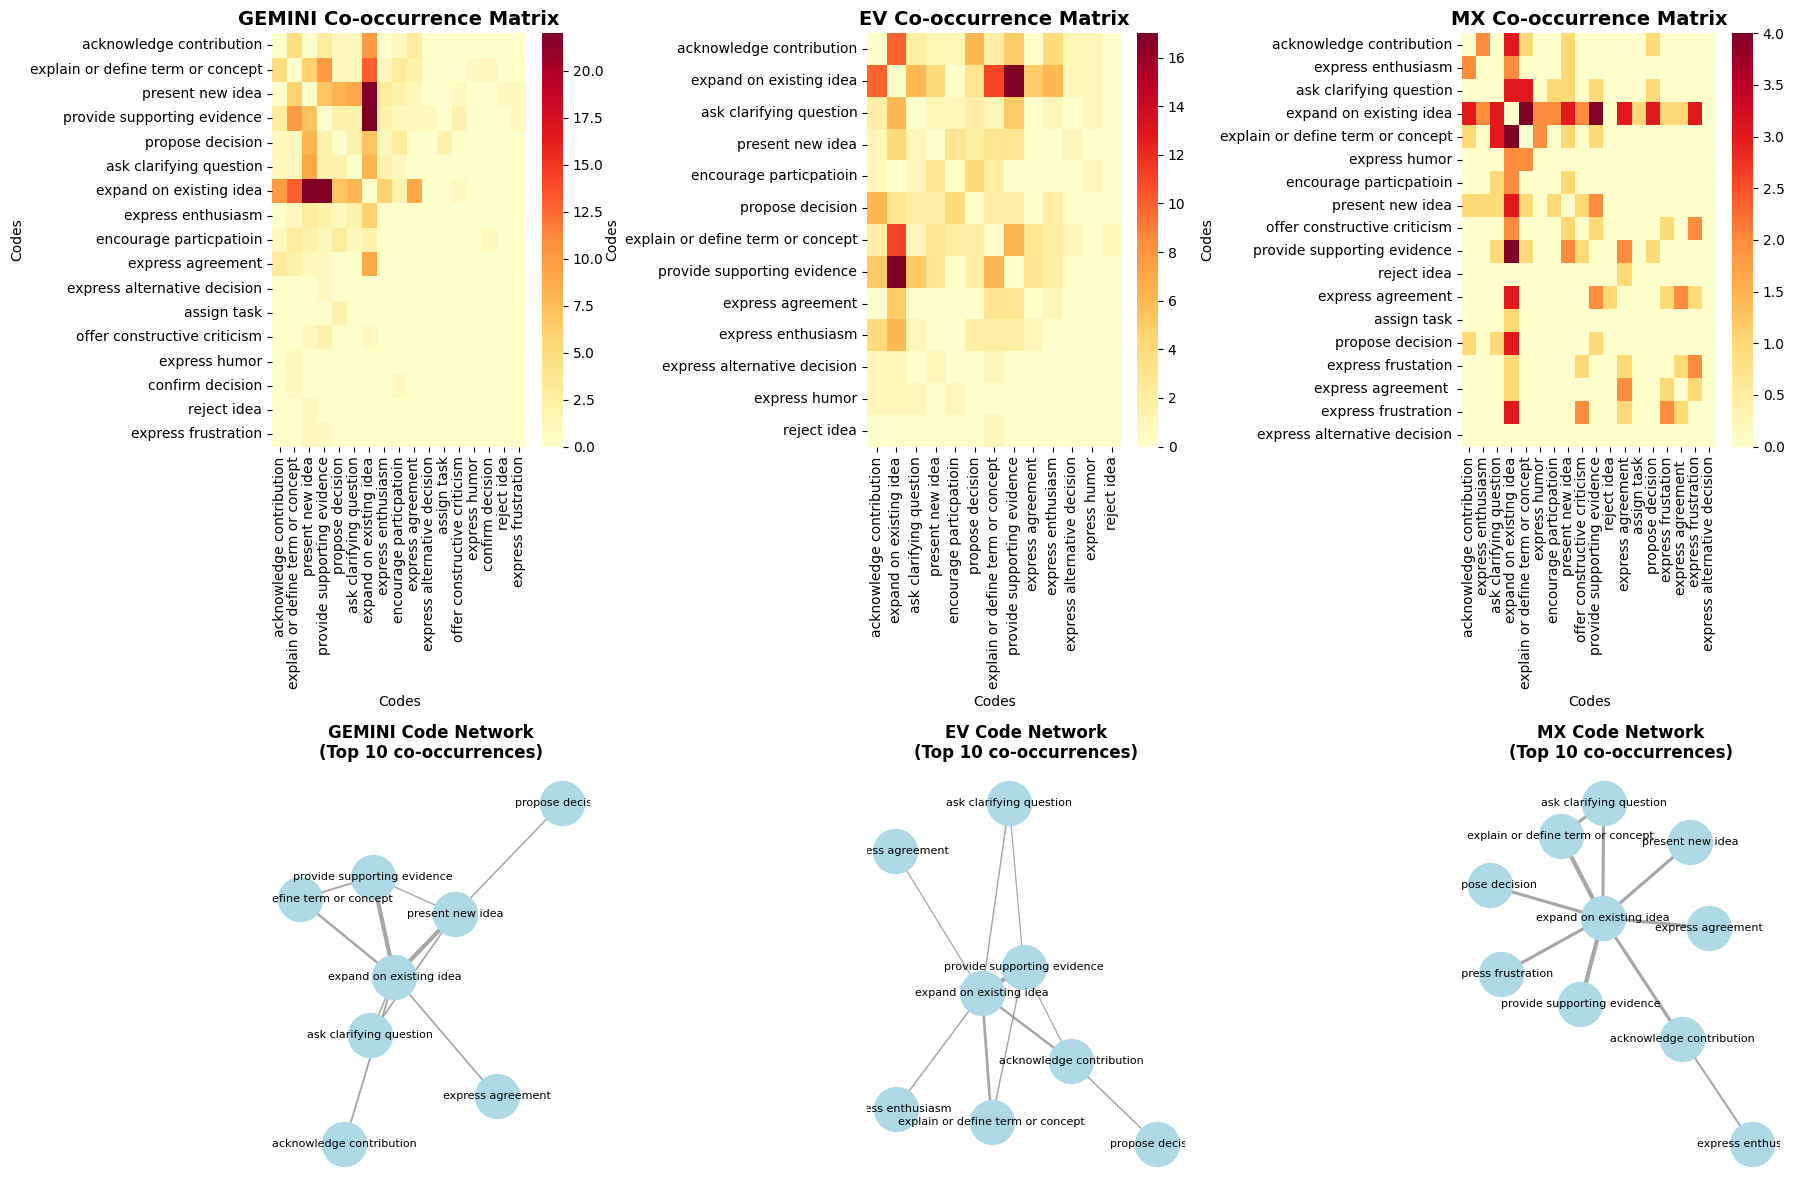


=== CO-OCCURRENCE SIMILARITY MATRIX ===
        gemini     ev     mx
gemini   1.000  0.774  0.680
ev       0.774  1.000  0.713
mx       0.680  0.713  1.000


/var/folders/v9/9n8npksj53380_v63d_r9jm80000gn/T/ipykernel_64339/469276669.py:264: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7744389173801632' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  similarity_matrix.loc[coder1, coder2] = correlation if not np.isnan(correlation) else 0
/var/folders/v9/9n8npksj53380_v63d_r9jm80000gn/T/ipykernel_64339/469276669.py:264: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6800027499515474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  similarity_matrix.loc[coder1, coder2] = correlation if not np.isnan(correlation) else 0
/var/folders/v9/9n8npksj53380_v63d_r9jm80000gn/T/ipykernel_64339/469276669.py:264: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

In [63]:
df = filtered_ann_df# or your data file

# Create co-occurrence matrices
cooccurrence_matrices = create_cooccurrence_matrix(df)

# Analyze patterns
analyze_cooccurrence_patterns(cooccurrence_matrices)

# Create visualizations
create_cooccurrence_visualizations(cooccurrence_matrices)

# Calculate similarity matrix
similarity_matrix = calculate_cooccurrence_similarity(cooccurrence_matrices)
print("\n=== CO-OCCURRENCE SIMILARITY MATRIX ===")
print(similarity_matrix.round(3))


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def pabak_from_confmat(cm):
    # cm: confusion matrix [[TN, FP], [FN, TP]]
    total = cm.sum()
    a = cm[0, 0]
    b = cm[0, 1]
    c = cm[1, 0]
    d = cm[1, 1]
    BI = (b-c)/total if total else np.nan
    PI = (a-d)/total if total else np.nan
    if total == 0:
        return np.nan, np.nan, np.nan, np.nan
    observed_agreement = (a+d) / total
    pabak = 2 * observed_agreement - 1
    k = (pabak - PI**2 + BI**2) / (1 - PI**2 + BI**2) if (1 - PI**2 + BI**2) != 0 else np.nan
    return BI, PI, pabak, k

def calculate_period_pabak_by_code(period_data, id_column, coder_column, code_column):
    """
    For each coder pair and each code, calculate PABAK.
    Returns a nested dict: {pair: {code: {'pabak':..., 'n':...}}}
    """
    agreement_metrics = {}
    coders = period_data[coder_column].unique()
    all_codes = period_data[code_column].unique()
    all_ids = period_data[id_column].unique()
    
    for i, coder1 in enumerate(coders):
        for coder2 in coders[i+1:]:
            pair_name = f"{coder1}-{coder2}"
            code_metrics = {}
            
            for code in all_codes:
                y1 = []
                y2 = []
                for id_ in all_ids:
                    c1_has = ((period_data[id_column] == id_) & (period_data[coder_column] == coder1) & (period_data[code_column] == code)).any()
                    c2_has = ((period_data[id_column] == id_) & (period_data[coder_column] == coder2) & (period_data[code_column] == code)).any()
                    y1.append(int(c1_has))
                    y2.append(int(c2_has))
                
                if sum(y1) + sum(y2) == 0:
                    continue  # skip codes not used by either coder in this window
                
                try:
                    cm = confusion_matrix(y1, y2, labels=[0,1])
                    bi, pi, pabak, k = pabak_from_confmat(cm)
                except:
                    pabak = np.nan
                
                code_metrics[code] = {'pabak': pabak, 'n': len(y1)}
            
            if code_metrics:
                agreement_metrics[pair_name] = code_metrics
    
    return agreement_metrics

def analyze_temporal_consistency_by_id(df, id_column='id', coder_column='coder', 
                                     code_column='code', window_size=10):
    """
    Analyze how PABAK agreement changes over time using ID increment as temporal pattern.
    Calculates PABAK for each code and coder pair in each time window.
    """
    print("=== TEMPORAL CONSISTENCY ANALYSIS (BY ID INCREMENT) ===")
    all_ids = sorted(df[id_column].unique())
    print(f"Total unique IDs: {len(all_ids)}")
    print(f"Window size: {window_size}")
    
    temporal_pabak = {}
    
    for i in range(0, len(all_ids), window_size):
        window_ids = all_ids[i:i+window_size]
        window_name = f"IDs_{i}-{i+len(window_ids)-1}"
        
        print(f"\n--- Time Window: {window_name} ---")
        
        window_data = df[df[id_column].isin(window_ids)]
        
        if len(window_data) == 0:
            continue
        
        print(f"Number of observations: {len(window_data)}")
        print(f"Number of unique IDs: {window_data[id_column].nunique()}")
        
        # Calculate PABAK by code
        window_pabak = calculate_period_pabak_by_code(window_data, id_column, coder_column, code_column)
        temporal_pabak[window_name] = window_pabak
        
        # Print PABAK results by code
        print("  PABAK by code:")
        for pair, code_metrics in window_pabak.items():
            for code, vals in code_metrics.items():
                print(f"    {pair} | {code}: PABAK={vals['pabak']:.3f}, n={vals['n']}")
    
    return temporal_pabak, all_ids

def analyze_learning_effects_by_id(df, id_column='id', coder_column='coder', 
                                 code_column='code', window_size=10):
    """
    Analyze learning effects by looking at PABAK over ID windows.
    """
    print("\n=== LEARNING EFFECTS ANALYSIS (BY ID WINDOWS) ===")
    
    # Get all unique IDs and sort them
    all_ids = sorted(df[id_column].unique())
    
    # Create windows
    window_pabak = {}
    window_count = 0
    
    for i in range(0, len(all_ids), window_size):
        window_ids = all_ids[i:i+window_size]
        window_name = f"Window_{window_count}"
        
        window_data = df[df[id_column].isin(window_ids)]
        
        if len(window_data) == 0:
            continue
        
        print(f"\n--- {window_name} (IDs {i}-{i+len(window_ids)-1}) ---")
        print(f"Number of observations: {len(window_data)}")
        
        # Calculate PABAK for this window
        window_metrics = calculate_period_pabak_by_code(window_data, id_column, coder_column, code_column)
        window_pabak[window_name] = window_metrics
        
        # Print results
        print("  PABAK by code:")
        for pair, code_metrics in window_metrics.items():
            for code, vals in code_metrics.items():
                print(f"    {pair} | {code}: PABAK={vals['pabak']:.3f}, n={vals['n']}")
        
        window_count += 1
    
    return window_pabak

def analyze_agreement_trends(df, id_column='id', coder_column='coder', 
                           code_column='code', window_size=10):
    """
    Analyze trends in PABAK over time using sliding windows.
    """
    print("\n=== AGREEMENT TRENDS ANALYSIS (SLIDING WINDOWS) ===")
    
    # Get all unique IDs and sort them
    all_ids = sorted(df[id_column].unique())
    
    # Use sliding windows for smoother trend analysis
    sliding_pabak = {}
    
    for i in range(len(all_ids) - window_size + 1):
        window_ids = all_ids[i:i+window_size]
        window_name = f"Sliding_{i}"
        
        window_data = df[df[id_column].isin(window_ids)]
        
        if len(window_data) == 0:
            continue
        
        # Calculate PABAK for this sliding window
        window_metrics = calculate_period_pabak_by_code(window_data, id_column, coder_column, code_column)
        sliding_pabak[window_name] = window_metrics
    
    return sliding_pabak

def create_temporal_visualizations(temporal_pabak, window_pabak, sliding_pabak, save_plots=True):
    """
    Create visualizations of PABAK temporal patterns using ID-based analysis.
    """
    plt.style.use('default')

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. PABAK over time windows
    ax1 = axes[0, 0]
    if temporal_pabak:
        # Extract data for plotting
        windows = list(temporal_pabak.keys())
        pairs = set()
        codes = set()
        for window_data in temporal_pabak.values():
            for pair_data in window_data.values():
                pairs.update(pair_data.keys())
                for code_data in pair_data.values():
                    codes.update(code_data.keys())
        
        # Plot PABAK for each code and pair
        for pair in pairs:
            for code in codes:
                pabaks = []
                for window in windows:
                    if (pair in temporal_pabak[window] and 
                        code in temporal_pabak[window][pair]):
                        pabaks.append(temporal_pabak[window][pair][code]['pabak'])
                    else:
                        pabaks.append(np.nan)
                
                if not all(np.isnan(pabaks)):
                    ax1.plot(range(len(windows)), pabaks, marker='o', 
                            label=f"{pair}-{code}", alpha=0.7)
        
        ax1.set_xlabel('Time Window (ID Range)', fontsize=12)
        ax1.set_ylabel('PABAK', fontsize=12)
        ax1.set_title('PABAK Over Time Windows', fontsize=14, fontweight='bold')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(alpha=0.3)
        ax1.set_xticks(range(len(windows)))
        ax1.set_xticklabels(windows, rotation=45)
    
    # 2. PABAK over fixed windows
    ax2 = axes[0, 1]
    if window_pabak:
        window_names = list(window_pabak.keys())
        pairs = set()
        codes = set()
        for window_data in window_pabak.values():
            for pair_data in window_data.values():
                pairs.update(pair_data.keys())
                for code_data in pair_data.values():
                    codes.update(code_data.keys())
        
        for pair in pairs:
            for code in codes:
                pabaks = []
                for window in window_names:
                    if (pair in window_pabak[window] and 
                        code in window_pabak[window][pair]):
                        pabaks.append(window_pabak[window][pair][code]['pabak'])
                    else:
                        pabaks.append(np.nan)
                
                if not all(np.isnan(pabaks)):
                    ax2.plot(range(len(window_names)), pabaks, marker='o', 
                            label=f"{pair}-{code}", alpha=0.7)
        
        ax2.set_xlabel('Window Number', fontsize=12)
        ax2.set_ylabel('PABAK', fontsize=12)
        ax2.set_title('PABAK Over Fixed Windows', fontsize=14, fontweight='bold')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(alpha=0.3)
        ax2.set_xticks(range(len(window_names)))
        ax2.set_xticklabels([f"W{i}" for i in range(len(window_names))])
    
    # 3. Average PABAK over time windows
    ax3 = axes[1, 0]
    if temporal_pabak:
        windows = list(temporal_pabak.keys())
        pairs = set()
        for window_data in temporal_pabak.values():
            pairs.update(window_data.keys())
        
        for pair in pairs:
            avg_pabaks = []
            for window in windows:
                if pair in temporal_pabak[window]:
                    # Calculate average PABAK across all codes for this pair
                    pabaks = [vals['pabak'] for vals in temporal_pabak[window][pair].values() 
                             if not np.isnan(vals['pabak'])]
                    avg_pabak = np.mean(pabaks) if pabaks else np.nan
                    avg_pabaks.append(avg_pabak)
                else:
                    avg_pabaks.append(np.nan)
            
            if not all(np.isnan(avg_pabaks)):
                ax3.plot(range(len(windows)), avg_pabaks, marker='s', label=pair, alpha=0.7)
        
        ax3.set_xlabel('Time Window (ID Range)', fontsize=12)
        ax3.set_ylabel('Average PABAK', fontsize=12)
        ax3.set_title('Average PABAK Over Time Windows', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(alpha=0.3)
        ax3.set_xticks(range(len(windows)))
        ax3.set_xticklabels(windows, rotation=45)
    
    # 4. Smooth trend using sliding windows
    ax4 = axes[1, 1]
    if sliding_pabak:
        sliding_names = list(sliding_pabak.keys())
        pairs = set()
        for window_data in sliding_pabak.values():
            pairs.update(window_data.keys())
        
        for pair in pairs:
            avg_pabaks = []
            for window in sliding_names:
                if pair in sliding_pabak[window]:
                    # Calculate average PABAK across all codes for this pair
                    pabaks = [vals['pabak'] for vals in sliding_pabak[window][pair].values() 
                             if not np.isnan(vals['pabak'])]
                    avg_pabak = np.mean(pabaks) if pabaks else np.nan
                    avg_pabaks.append(avg_pabak)
                else:
                    avg_pabaks.append(np.nan)
            
            if not all(np.isnan(avg_pabaks)):
                ax4.plot(range(len(sliding_names)), avg_pabaks, marker='', 
                        label=pair, alpha=0.7, linewidth=2)
        
        ax4.set_xlabel('Sliding Window Position', fontsize=12)
        ax4.set_ylabel('Average PABAK', fontsize=12)
        ax4.set_title('Smooth PABAK Trend (Sliding Windows)', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('temporal_consistency_analysis.png', dpi=300, bbox_inches='tight')
        print("Plot saved as: temporal_consistency_analysis.png")
    
    plt.show()

def analyze_early_vs_late_agreement(df, id_column='id', coder_column='coder', 
                                  code_column='code', split_point=None):
    """
    Compare PABAK in early vs late coding periods.
    """
    print("\n=== EARLY VS LATE AGREEMENT ANALYSIS ===")
    
    # Get all unique IDs and sort them
    all_ids = sorted(df[id_column].unique())
    
    if split_point is None:
        split_point = all_ids[len(all_ids) // 2]
    
    print(f"Split point: ID {split_point}")
    print(f"Early period: IDs 0-{split_point-1}")
    print(f"Late period: IDs {split_point}-{max(all_ids)}")
    
    # Split data
    early_ids = [id_ for id_ in all_ids if id_ < split_point]
    late_ids = [id_ for id_ in all_ids if id_ >= split_point]
    
    early_data = df[df[id_column].isin(early_ids)]
    late_data = df[df[id_column].isin(late_ids)]
    
    print(f"\nEarly period observations: {len(early_data)}")
    print(f"Late period observations: {len(late_data)}")
    
    # Calculate PABAK for each period
    early_pabak = calculate_period_pabak_by_code(early_data, id_column, coder_column, code_column)
    late_pabak = calculate_period_pabak_by_code(late_data, id_column, coder_column, code_column)
    
    print("\nEarly Period PABAK:")
    for pair, code_metrics in early_pabak.items():
        for code, vals in code_metrics.items():
            print(f"  {pair} | {code}: PABAK={vals['pabak']:.3f}, n={vals['n']}")
    
    print("\nLate Period PABAK:")
    for pair, code_metrics in late_pabak.items():
        for code, vals in code_metrics.items():
            print(f"  {pair} | {code}: PABAK={vals['pabak']:.3f}, n={vals['n']}")
    
    # Calculate differences
    print("\nPABAK Changes (Late - Early):")
    for pair in early_pabak.keys():
        if pair in late_pabak:
            for code in early_pabak[pair].keys():
                if code in late_pabak[pair]:
                    early_pabak_val = early_pabak[pair][code]['pabak']
                    late_pabak_val = late_pabak[pair][code]['pabak']
                    if not np.isnan(early_pabak_val) and not np.isnan(late_pabak_val):
                        change = late_pabak_val - early_pabak_val
                        print(f"  {pair} | {code}: {change:+.3f} ({'Improvement' if change > 0 else 'Decline'})")
    
    return {
        'early': early_pabak,
        'late': late_pabak,
        'split_point': split_point
    }



=== TEMPORAL CONSISTENCY ANALYSIS (BY ID INCREMENT) ===
Total unique IDs: 117
Window size: 20

--- Time Window: IDs_0-19 ---
Number of observations: 133
Number of unique IDs: 20
  PABAK by code:
    gemini-ev | acknowledge contribution: PABAK=0.800, n=20
    gemini-ev | explain or define term or concept: PABAK=0.700, n=20
    gemini-ev | present new idea: PABAK=0.200, n=20
    gemini-ev | provide supporting evidence: PABAK=0.400, n=20
    gemini-ev | propose decision: PABAK=0.700, n=20
    gemini-ev | ask clarifying question: PABAK=0.900, n=20
    gemini-ev | expand on existing idea: PABAK=-0.100, n=20
    gemini-ev | express enthusiasm: PABAK=0.600, n=20
    gemini-ev | encourage particpatioin: PABAK=0.400, n=20
    gemini-ev | express agreement: PABAK=0.900, n=20
    gemini-ev | express alternative decision: PABAK=0.800, n=20
    gemini-ev | assign task: PABAK=0.900, n=20
    gemini-mx | acknowledge contribution: PABAK=0.700, n=20
    gemini-mx | explain or define term or concept: PA

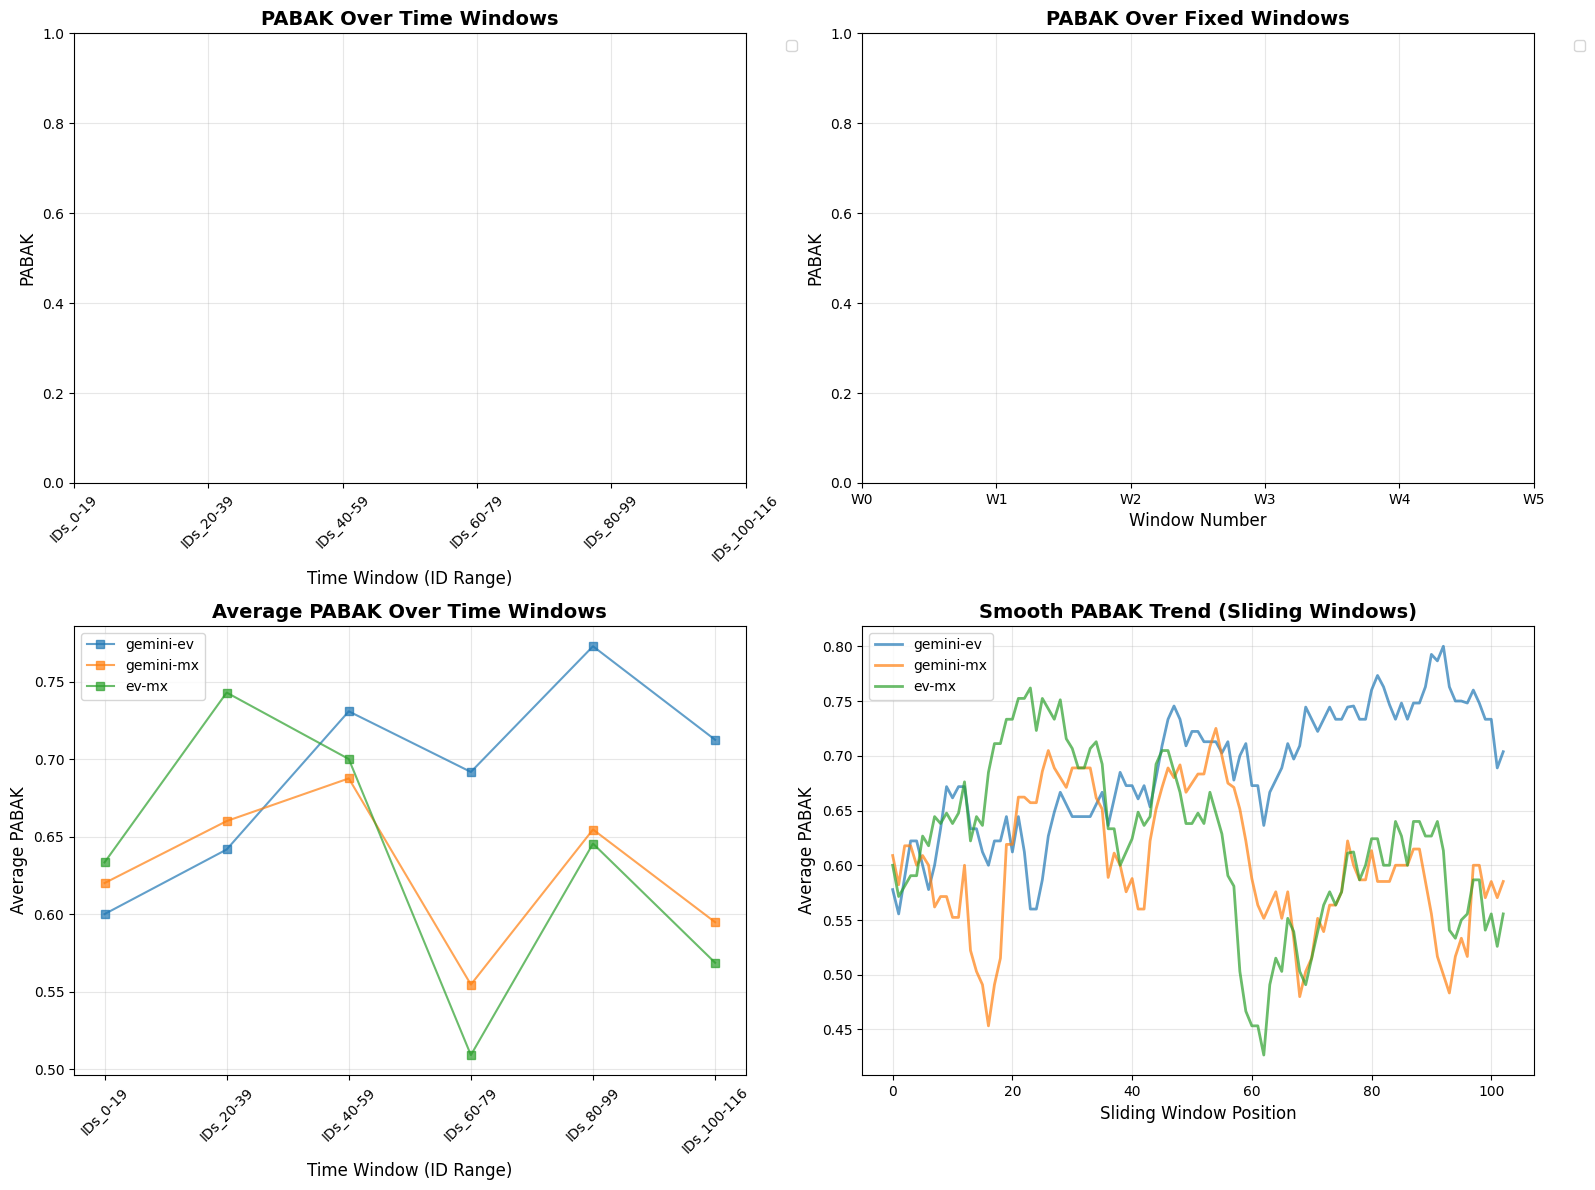

In [71]:
df = filtered_ann_df

# Analyze temporal consistency using ID increment
temporal_pabak, all_ids = analyze_temporal_consistency_by_id(df, window_size=20)

# Analyze learning effects
window_pabak = analyze_learning_effects_by_id(df, window_size=20)

# Analyze trends with sliding windows
sliding_pabak = analyze_agreement_trends(df, window_size=15)

# Compare early vs late agreement
early_late_comparison = analyze_early_vs_late_agreement(df)

# Create visualizations
create_temporal_visualizations(temporal_pabak, window_pabak, sliding_pabak)
        
